In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from timeit import default_timer as timer
from datetime import timedelta

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc');
octave.addpath(eeglab_path + 'popfunc');
octave.addpath(eeglab_path + 'adminfunc');
octave.addpath(eeglab_path + 'sigprocfunc');
octave.addpath(eeglab_path + 'miscfunc');

In [3]:
experiment = 'data/original/*/*'
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean-prestimulus.set'))
eeg_present = len(eegs) > 0
cmaps = sorted(glob.glob(experiment + '/cmap/*.xlsx'))
cmap_present = len(cmaps) > 0
all_present = mep_present and eeg_present and cmap_present
print(all_present)

True


In [4]:
print('EEG count: ' + str(len(eegs)))
print('MEP count: ' + str(len(meps)))
print('CMAP count: ' + str(len(cmaps)))

EEG count: 44
MEP count: 77
CMAP count: 22


In [5]:
eegs

['data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp02/eeg/SP 120RMT r2/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP

In [6]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set', NO CMAP
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
#     'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set', LEFT HANDED
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r3/clean-prestimulus.set'
]

# Read and process EEG

In [7]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

# Calculate EEG area.
def calculate_eeg_area(epoch_df, sf=2048):
    y = epoch_df.drop('time', axis=1).mean(axis=1)
    b2, a2 = signal.butter(4, 200/(sf/2), btype='lowpass')
    envelope = signal.filtfilt(b2, a2, np.abs(y))
    area = np.trapz(envelope, epoch_df['time'].values)
    return area

# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 2048
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

def band_max(freq, psd, interval):
    indices = []
    for el in freq:
        indices.append(el in interval)
    freq = freq[indices]
    psd = psd[indices]
    if (len(psd) == 0):
        return 0, 0
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

def read_wavelets(sub, exp, run, epoch_num):
    path = 'wavelets-69/' + sub + '-' + exp + '-' + run + '-' + str(epoch_num)
    with open(path + '-central.pickle', 'rb') as f:
        central = pickle.load(f)
    with open(path + '-ltm1.pickle', 'rb') as f:
        ltm1 = pickle.load(f)
    with open(path + '-rtm1.pickle', 'rb') as f:
        rtm1 = pickle.load(f)
    with open(path + '-all.pickle', 'rb') as f:
        all_channels = pickle.load(f)
    with open(path + '-ltdlpfc.pickle', 'rb') as f:
        ltdlpfc = pickle.load(f)
    with open(path + '-rtdlpfc.pickle', 'rb') as f:
        rtdlpfc = pickle.load(f)
    with open(path + '-ltparietal.pickle', 'rb') as f:
        ltparietal = pickle.load(f)
    with open(path + '-rtparietal.pickle', 'rb') as f:
        rtparietal = pickle.load(f)
    with open(path + '-occipital.pickle', 'rb') as f:
        occipital = pickle.load(f)
    with open(path + '-ltoccipital.pickle', 'rb') as f:
        ltoccipital = pickle.load(f)
    with open(path + '-rtoccipital.pickle', 'rb') as f:
        rtoccipital = pickle.load(f)
    return all_channels, ltm1, rtm1, central, ltdlpfc, rtdlpfc, ltparietal, rtparietal, occipital, ltoccipital, rtoccipital

def wavelet_band_max(df, interval):
    indices = []
    for el in (df.index * 1000):
        indices.append(el in interval)
    df = df[indices]
    if (df.shape[0] == 0):
        return 0, 0, 0, 0
    return df.mean(axis=1).max(), df.mean(axis=1).argmax() * 1000, df.mean(axis=0).max(), df.mean(axis=0).argmax()

def normalize_image(image, mx=1, mn=0):
    wt_min = image.min().min()
    std = (image.values - wt_min) / (image.max().max() - wt_min)
    image.loc[:, :] = std * (mx - mn) + mn
    return image

# Read features file

In [8]:
features_filename = '55-features-v2.xlsx'

In [9]:
df = pd.read_excel(features_filename, index_col=0)

p1 = np.percentile(df['mep_category_cmap'], 50)
cat = np.ones(len(df['mep_category_cmap'])) * (df['mep_category_cmap'] > p1)
df['mep_category_cmap_across_subjects'] = cat

# Add all wavelets

In [10]:
start_time = -500

In [11]:
def load_wavelets_to_memory(idx, epoch):
    wt_all, wt_ltm1, wt_rtm1, wt_central, wt_ltdlpfc, wt_rtdlpfc, wt_ltparietal, wt_rtparietal, wt_occipital, wt_ltoccipital, wt_rtoccipital = read_wavelets(epoch['sub'], epoch['exp'], epoch['run'], epoch['epoch'])
    return epoch['mep_category_cmap_across_subjects'], wt_all, wt_ltm1, wt_rtm1, wt_central, wt_ltdlpfc, wt_rtdlpfc, wt_ltparietal, wt_rtparietal, wt_occipital, wt_ltoccipital, wt_rtoccipital

In [12]:
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(load_wavelets_to_memory)(idx, epoch) for idx, epoch in tqdm_notebook(df.iterrows(), total=df.shape[0]))

In [13]:
wt_large_all_all = wt_large_ltm1_all = wt_large_rtm1_all = wt_large_central_all = wt_large_ltdlpfc_all = wt_large_rtdlpfc_all = wt_large_ltparietal_all = wt_large_rtparietal_all = wt_large_occipital_all = wt_large_ltoccipital_all = wt_large_rtoccipital_all = wt_small_all_all = wt_small_ltm1_all = wt_small_rtm1_all = wt_small_central_all = wt_small_ltdlpfc_all = wt_small_rtdlpfc_all = wt_small_ltparietal_all = wt_small_rtparietal_all = wt_small_occipital_all = wt_small_ltoccipital_all = wt_small_rtoccipital_all = np.zeros((73, 1024))

def sum_wavelets(wt_epoch):
    global wt_large_all_all, wt_large_ltm1_all, wt_large_rtm1_all, wt_large_central_all, wt_large_ltdlpfc_all, wt_large_rtdlpfc_all, wt_large_ltparietal_all, wt_large_rtparietal_all, wt_large_occipital_all, wt_large_ltoccipital_all, wt_large_rtoccipital_all, wt_small_all_all, wt_small_ltm1_all, wt_small_rtm1_all, wt_small_central_all, wt_small_ltdlpfc_all, wt_small_rtdlpfc_all, wt_small_ltparietal_all, wt_small_rtparietal_all, wt_small_occipital_all, wt_small_ltoccipital_all, wt_small_rtoccipital_all
    if wt_epoch[0]:
        wt_large_all_all = np.add(wt_large_all_all, normalize_image(wt_epoch[1]))
        wt_large_ltm1_all = np.add(wt_large_ltm1_all, normalize_image(wt_epoch[2]))
        wt_large_rtm1_all = np.add(wt_large_rtm1_all, normalize_image(wt_epoch[3]))
        wt_large_central_all = np.add(wt_large_central_all, normalize_image(wt_epoch[4]))
        wt_large_ltdlpfc_all = np.add(wt_large_ltdlpfc_all, normalize_image(wt_epoch[5]))
        wt_large_rtdlpfc_all = np.add(wt_large_rtdlpfc_all, normalize_image(wt_epoch[6]))
        wt_large_ltparietal_all = np.add(wt_large_ltparietal_all, normalize_image(wt_epoch[7]))
        wt_large_rtparietal_all = np.add(wt_large_rtparietal_all, normalize_image(wt_epoch[8]))
        wt_large_occipital_all = np.add(wt_large_occipital_all, normalize_image(wt_epoch[9]))
        wt_large_ltoccipital_all = np.add(wt_large_ltoccipital_all, normalize_image(wt_epoch[10]))
        wt_large_rtoccipital_all = np.add(wt_large_rtoccipital_all, normalize_image(wt_epoch[11]))
    else:
        wt_small_all_all = np.add(wt_small_all_all, normalize_image(wt_epoch[1]))
        wt_small_ltm1_all = np.add(wt_small_ltm1_all, normalize_image(wt_epoch[2]))
        wt_small_rtm1_all = np.add(wt_small_rtm1_all, normalize_image(wt_epoch[3]))
        wt_small_central_all = np.add(wt_small_central_all, normalize_image(wt_epoch[4]))
        wt_small_ltdlpfc_all = np.add(wt_small_ltdlpfc_all, normalize_image(wt_epoch[5]))
        wt_small_rtdlpfc_all = np.add(wt_small_rtdlpfc_all, normalize_image(wt_epoch[6]))
        wt_small_ltparietal_all = np.add(wt_small_ltparietal_all, normalize_image(wt_epoch[7]))
        wt_small_rtparietal_all = np.add(wt_small_rtparietal_all, normalize_image(wt_epoch[8]))
        wt_small_occipital_all = np.add(wt_small_occipital_all, normalize_image(wt_epoch[9]))
        wt_small_ltoccipital_all = np.add(wt_small_ltoccipital_all, normalize_image(wt_epoch[10]))
        wt_small_rtoccipital_all = np.add(wt_small_rtoccipital_all, normalize_image(wt_epoch[11]))

for wt_epoch in tqdm_notebook(results):
    sum_wavelets(wt_epoch)

In [14]:
# All
wt_large_all_all.columns = np.round(wt_large_all_all.columns, 3)
wt_small_all_all.columns = np.round(wt_small_all_all.columns, 3)
wt_large_all_all.index = np.round(wt_large_all_all.index*1000, 2)
wt_small_all_all.index = np.round(wt_small_all_all.index*1000, 2)

# LtM1
wt_large_ltm1_all.columns = np.round(wt_large_ltm1_all.columns, 3)
wt_small_ltm1_all.columns = np.round(wt_small_ltm1_all.columns, 3)
wt_large_ltm1_all.index = np.round(wt_large_ltm1_all.index*1000, 2)
wt_small_ltm1_all.index = np.round(wt_small_ltm1_all.index*1000, 2)

# RtM1
wt_large_rtm1_all.columns = np.round(wt_large_rtm1_all.columns, 3)
wt_small_rtm1_all.columns = np.round(wt_small_rtm1_all.columns, 3)
wt_large_rtm1_all.index = np.round(wt_large_rtm1_all.index*1000, 2)
wt_small_rtm1_all.index = np.round(wt_small_rtm1_all.index*1000, 2)

# Central
wt_large_central_all.columns = np.round(wt_large_central_all.columns, 3)
wt_small_central_all.columns = np.round(wt_small_central_all.columns, 3)
wt_large_central_all.index = np.round(wt_large_central_all.index*1000, 2)
wt_small_central_all.index = np.round(wt_small_central_all.index*1000, 2)

# ltdlpfc
wt_large_ltdlpfc_all.columns = np.round(wt_large_ltdlpfc_all.columns, 3)
wt_small_ltdlpfc_all.columns = np.round(wt_small_ltdlpfc_all.columns, 3)
wt_large_ltdlpfc_all.index = np.round(wt_large_ltdlpfc_all.index*1000, 2)
wt_small_ltdlpfc_all.index = np.round(wt_small_ltdlpfc_all.index*1000, 2)

# rtdlpfc
wt_large_rtdlpfc_all.columns = np.round(wt_large_rtdlpfc_all.columns, 3)
wt_small_rtdlpfc_all.columns = np.round(wt_small_rtdlpfc_all.columns, 3)
wt_large_rtdlpfc_all.index = np.round(wt_large_rtdlpfc_all.index*1000, 2)
wt_small_rtdlpfc_all.index = np.round(wt_small_rtdlpfc_all.index*1000, 2)

# ltparietal
wt_large_ltparietal_all.columns = np.round(wt_large_ltparietal_all.columns, 3)
wt_small_ltparietal_all.columns = np.round(wt_small_ltparietal_all.columns, 3)
wt_large_ltparietal_all.index = np.round(wt_large_ltparietal_all.index*1000, 2)
wt_small_ltparietal_all.index = np.round(wt_small_ltparietal_all.index*1000, 2)

# rtparietal
wt_large_rtparietal_all.columns = np.round(wt_large_rtparietal_all.columns, 3)
wt_small_rtparietal_all.columns = np.round(wt_small_rtparietal_all.columns, 3)
wt_large_rtparietal_all.index = np.round(wt_large_rtparietal_all.index*1000, 2)
wt_small_rtparietal_all.index = np.round(wt_small_rtparietal_all.index*1000, 2)

# occipital
wt_large_occipital_all.columns = np.round(wt_large_occipital_all.columns, 3)
wt_small_occipital_all.columns = np.round(wt_small_occipital_all.columns, 3)
wt_large_occipital_all.index = np.round(wt_large_occipital_all.index*1000, 2)
wt_small_occipital_all.index = np.round(wt_small_occipital_all.index*1000, 2)

# ltoccipital
wt_large_ltoccipital_all.columns = np.round(wt_large_ltoccipital_all.columns, 3)
wt_small_ltoccipital_all.columns = np.round(wt_small_ltoccipital_all.columns, 3)
wt_large_ltoccipital_all.index = np.round(wt_large_ltoccipital_all.index*1000, 2)
wt_small_ltoccipital_all.index = np.round(wt_small_ltoccipital_all.index*1000, 2)

# rtoccipital
wt_large_rtoccipital_all.columns = np.round(wt_large_rtoccipital_all.columns, 3)
wt_small_rtoccipital_all.columns = np.round(wt_small_rtoccipital_all.columns, 3)
wt_large_rtoccipital_all.index = np.round(wt_large_rtoccipital_all.index*1000, 2)
wt_small_rtoccipital_all.index = np.round(wt_small_rtoccipital_all.index*1000, 2)

In [15]:
def plot_power_sums(wt_large, wt_small, title):
    f, axs = plt.subplots(1, 3, figsize=(20,5))
    
    sns.heatmap(wt_large, ax=axs[0])
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Frequency (Hz)')
    axs[0].set_title('Mean normalized power of large MEP')
    
    sns.heatmap(wt_small, ax=axs[1])
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_title('Mean normalized power of small MEP')
    
    sns.heatmap(np.add(wt_large, -wt_small), ax=axs[2])
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Frequency (Hz)')
    axs[2].set_title('Difference of mean normalized power')
    
    f.suptitle(title)

# LtM1

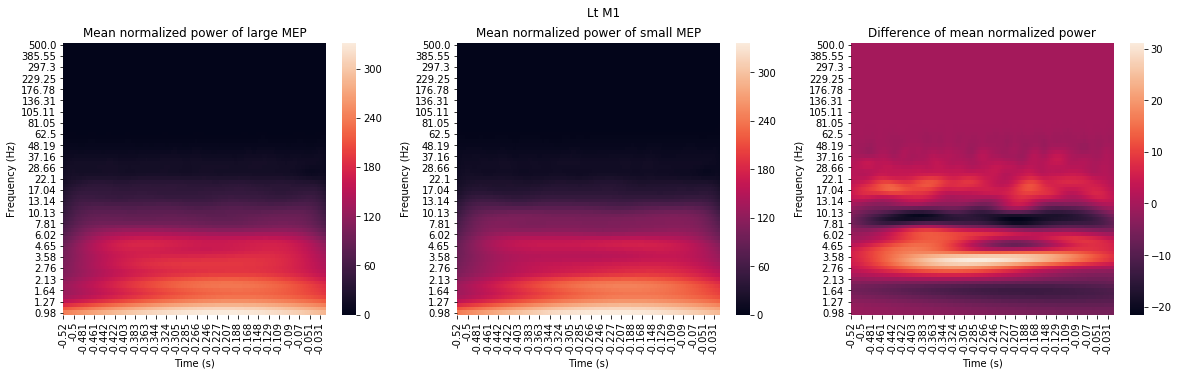

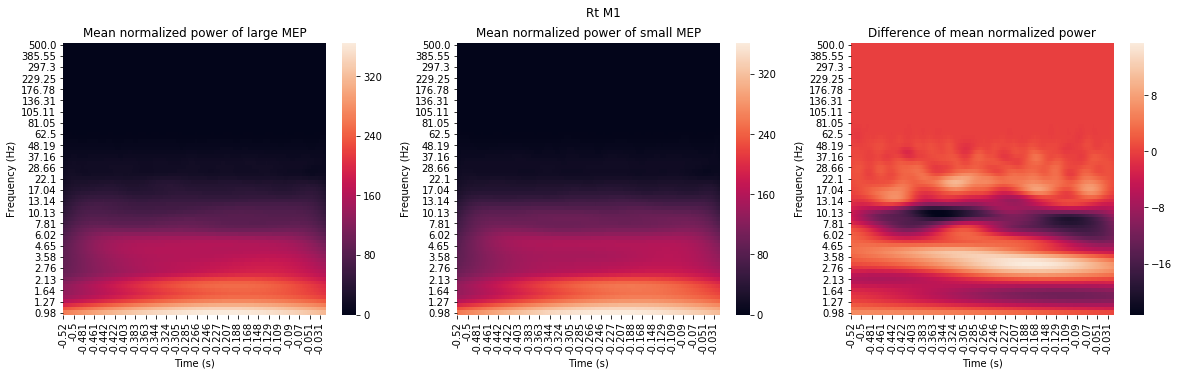

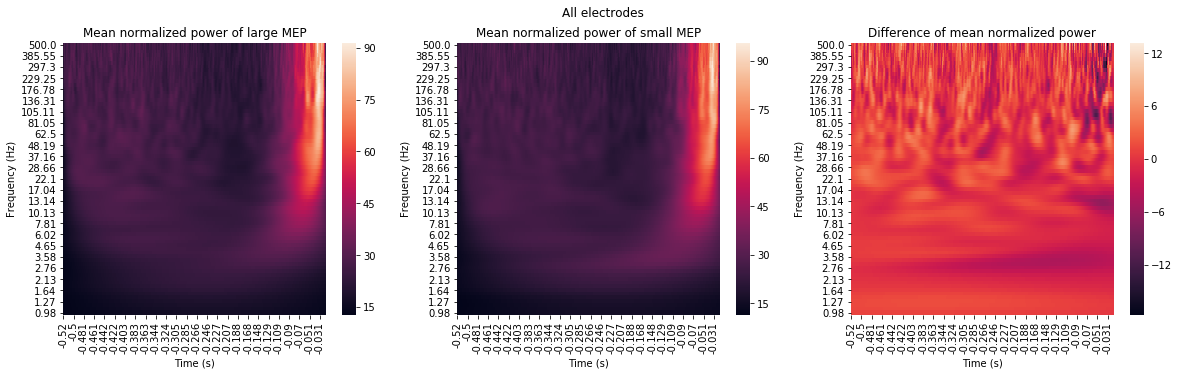

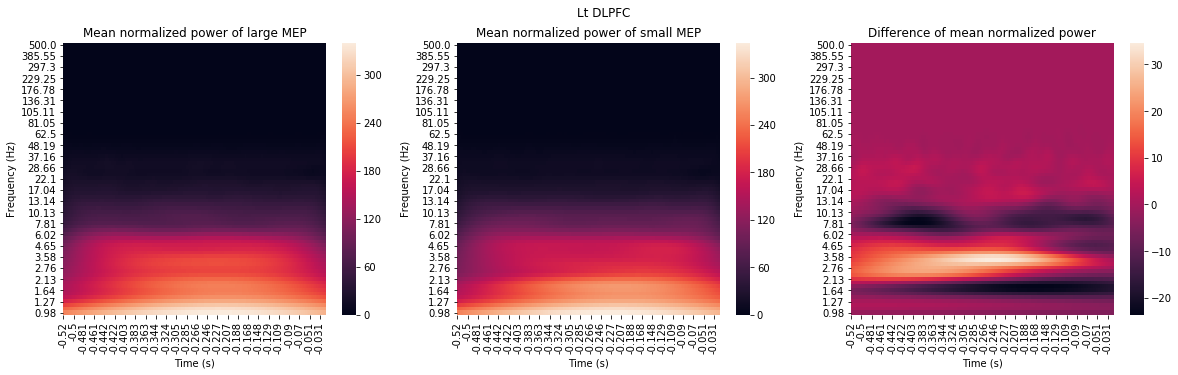

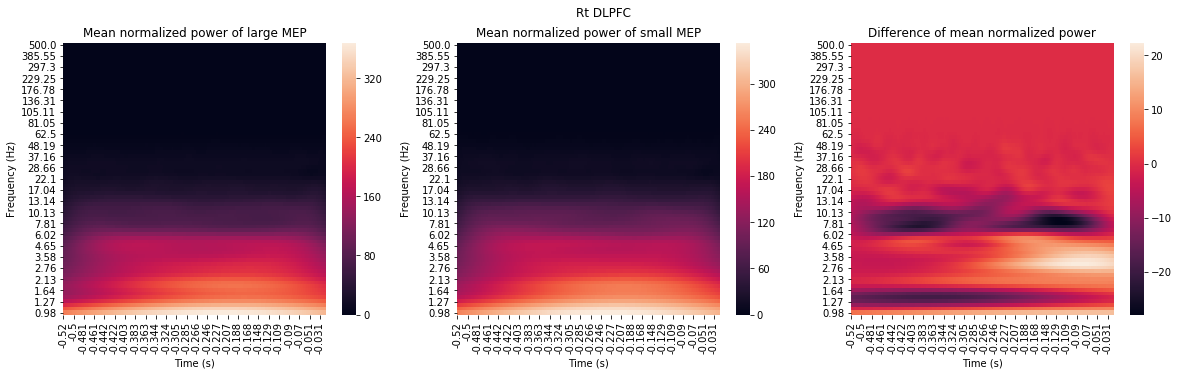

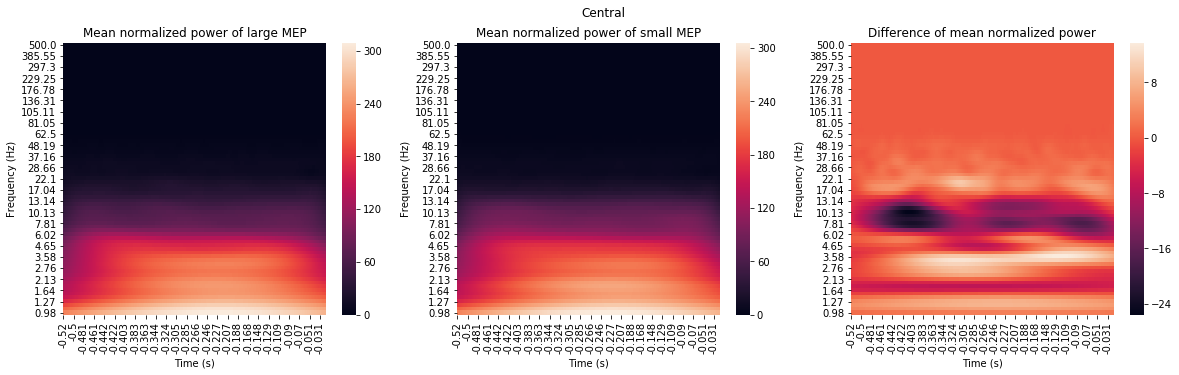

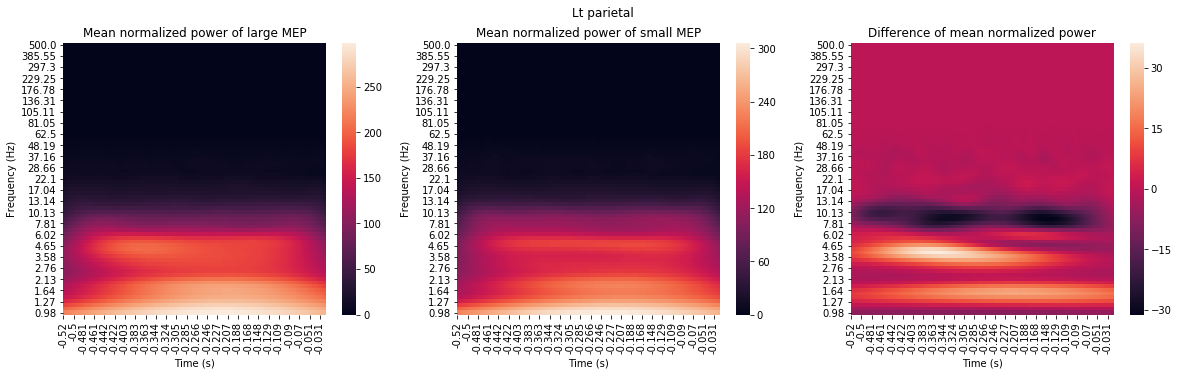

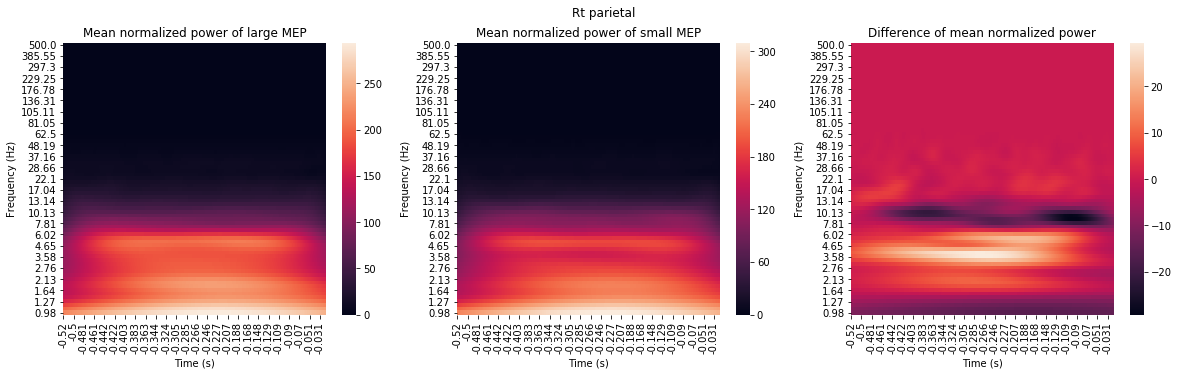

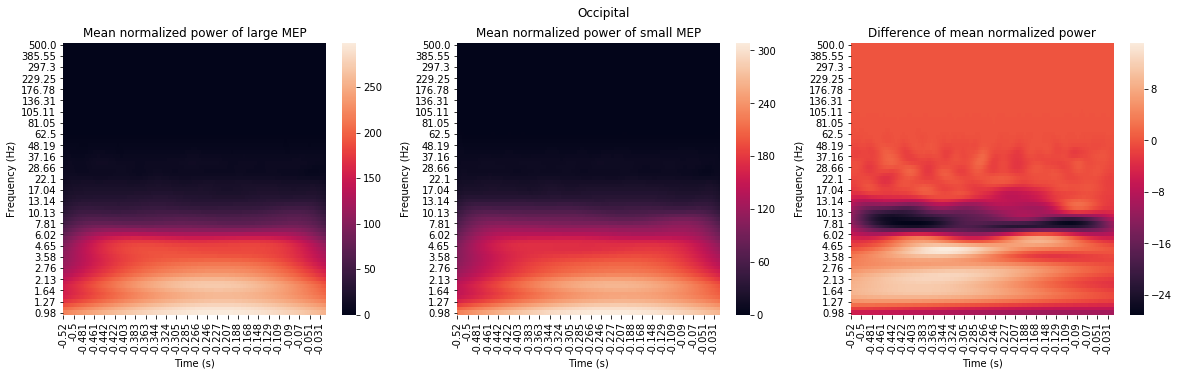

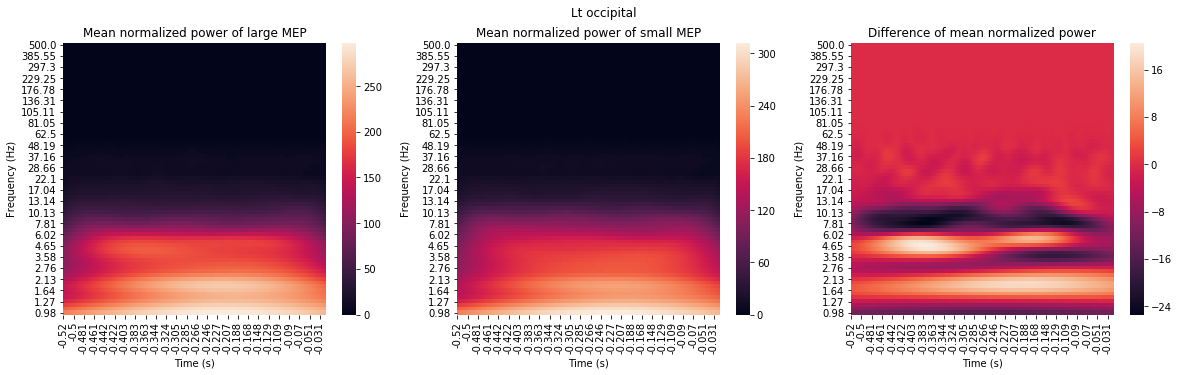

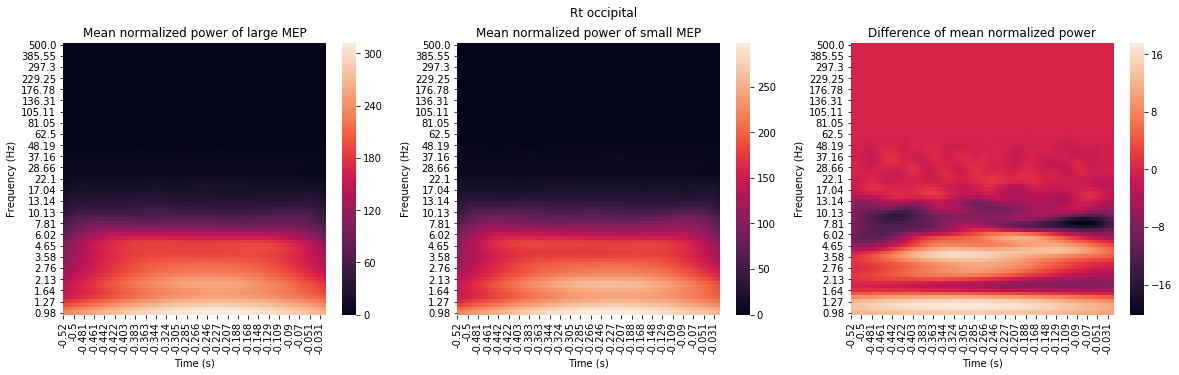

In [16]:
plot_power_sums(wt_large_ltm1_all, wt_small_ltm1_all, 'Lt M1')
plot_power_sums(wt_large_rtm1_all, wt_small_rtm1_all, 'Rt M1')
plot_power_sums(wt_large_all_all, wt_small_all_all, 'All electrodes')
plot_power_sums(wt_large_ltdlpfc_all, wt_small_ltdlpfc_all, 'Lt DLPFC')
plot_power_sums(wt_large_rtdlpfc_all, wt_small_rtdlpfc_all, 'Rt DLPFC')
plot_power_sums(wt_large_central_all, wt_small_central_all, 'Central')
plot_power_sums(wt_large_ltparietal_all, wt_small_ltparietal_all, 'Lt parietal')
plot_power_sums(wt_large_rtparietal_all, wt_small_rtparietal_all, 'Rt parietal')
plot_power_sums(wt_large_occipital_all, wt_small_occipital_all, 'Occipital')
plot_power_sums(wt_large_ltoccipital_all, wt_small_ltoccipital_all, 'Lt occipital')
plot_power_sums(wt_large_rtoccipital_all, wt_small_rtoccipital_all, 'Rt occipital')

# Correlation

In [17]:
def crop_wavelet(wt, start_time_millis = -25, end_time_millis = -20, start_freq = 2, end_freq = 20):
    wt = wt[(wt.index * 1000 > start_freq) * (wt.index * 1000 < end_freq)]
    wt = wt.loc[:, wt.columns.isin(wt.columns[(wt.columns >= (start_time_millis/1000)) * (wt.columns <= (end_time_millis/1000))])]
    wt.columns = np.round(wt.columns, 3)
    wt.index = np.round(wt.index*1000, 2)
    wt = normalize_image(wt)
    return wt

def populate_corr(wt, df_corr_el):
    for time, column in wt.iteritems():
        for freq, row in pd.DataFrame(column).iterrows():
            df_corr_el['power_' + str(time) + '_' + str(freq)] = row.values[0]
    return df_corr_el

In [18]:
df_corr_ltm1 = []
df_corr_rtm1 = []
df_corr_central = []
df_corr_all = []
df_corr_ltdlpfc = []
df_corr_rtdlpfc = []
df_corr_ltparietal = []
df_corr_rtparietal = []
df_corr_occipital = []
df_corr_ltoccipital = []
df_corr_rtoccipital = []
        
for idx, epoch in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    wt_all, wt_ltm1, wt_rtm1, wt_central, wt_ltdlpfc, wt_rtdlpfc, wt_ltparietal, wt_rtparietal, wt_occipital, wt_ltoccipital, wt_rtoccipital = read_wavelets(epoch['sub'], epoch['exp'], epoch['run'], epoch['epoch'])
    wt_all, wt_ltm1, wt_rtm1, wt_central, wt_ltdlpfc, wt_rtdlpfc, wt_ltparietal, wt_rtparietal, wt_occipital, wt_ltoccipital, wt_rtoccipital = normalize_image(wt_all), normalize_image(wt_ltm1), normalize_image(wt_rtm1), normalize_image(wt_central), normalize_image(wt_ltdlpfc), normalize_image(wt_rtdlpfc), normalize_image(wt_ltparietal), normalize_image(wt_rtparietal), normalize_image(wt_occipital), normalize_image(wt_ltoccipital), normalize_image(wt_rtoccipital)

    # Crop frequencies and time.
    wt_ltm1 = crop_wavelet(wt_ltm1)
    wt_rtm1 = crop_wavelet(wt_rtm1)
    wt_all = crop_wavelet(wt_all)
    wt_central = crop_wavelet(wt_central)
    wt_ltdlpfc = crop_wavelet(wt_ltdlpfc)
    wt_rtdlpfc = crop_wavelet(wt_rtdlpfc)
    wt_ltparietal = crop_wavelet(wt_ltparietal)
    wt_rtparietal = crop_wavelet(wt_rtparietal)
    wt_occipital = crop_wavelet(wt_occipital)
    wt_ltoccipital = crop_wavelet(wt_ltoccipital)
    wt_rtoccipital = crop_wavelet(wt_rtoccipital)

    df_corr_el = {
        'mep_category_absolute': epoch['mep_category_absolute'],
        'mep_category_cmap_across_subjects': epoch['mep_category_cmap_across_subjects'],
        'mep_size': epoch['mep_size'],
        'mep_category_percentile': epoch['mep_category_percentile']
    }

    df_corr_ltm1.append(populate_corr(wt_ltm1, df_corr_el))
    df_corr_rtm1.append(populate_corr(wt_rtm1, df_corr_el))
    df_corr_all.append(populate_corr(wt_all, df_corr_el))
    df_corr_central.append(populate_corr(wt_central, df_corr_el))
    df_corr_ltdlpfc.append(populate_corr(wt_ltdlpfc, df_corr_el))
    df_corr_rtdlpfc.append(populate_corr(wt_rtdlpfc, df_corr_el))
    df_corr_ltparietal.append(populate_corr(wt_ltparietal, df_corr_el))
    df_corr_rtparietal.append(populate_corr(wt_rtparietal, df_corr_el))
    df_corr_occipital.append(populate_corr(wt_occipital, df_corr_el))
    df_corr_ltoccipital.append(populate_corr(wt_ltoccipital, df_corr_el))
    df_corr_rtoccipital.append(populate_corr(wt_rtoccipital, df_corr_el))

In [19]:
def plot_corr(corr_arr, title):
    df_corr = pd.DataFrame(corr_arr)
    f = plt.figure(figsize=(62, 28))
    plt.matshow(np.abs(df_corr.corr()), fignum=f.number)
    plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14, rotation=45)
    plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=16)

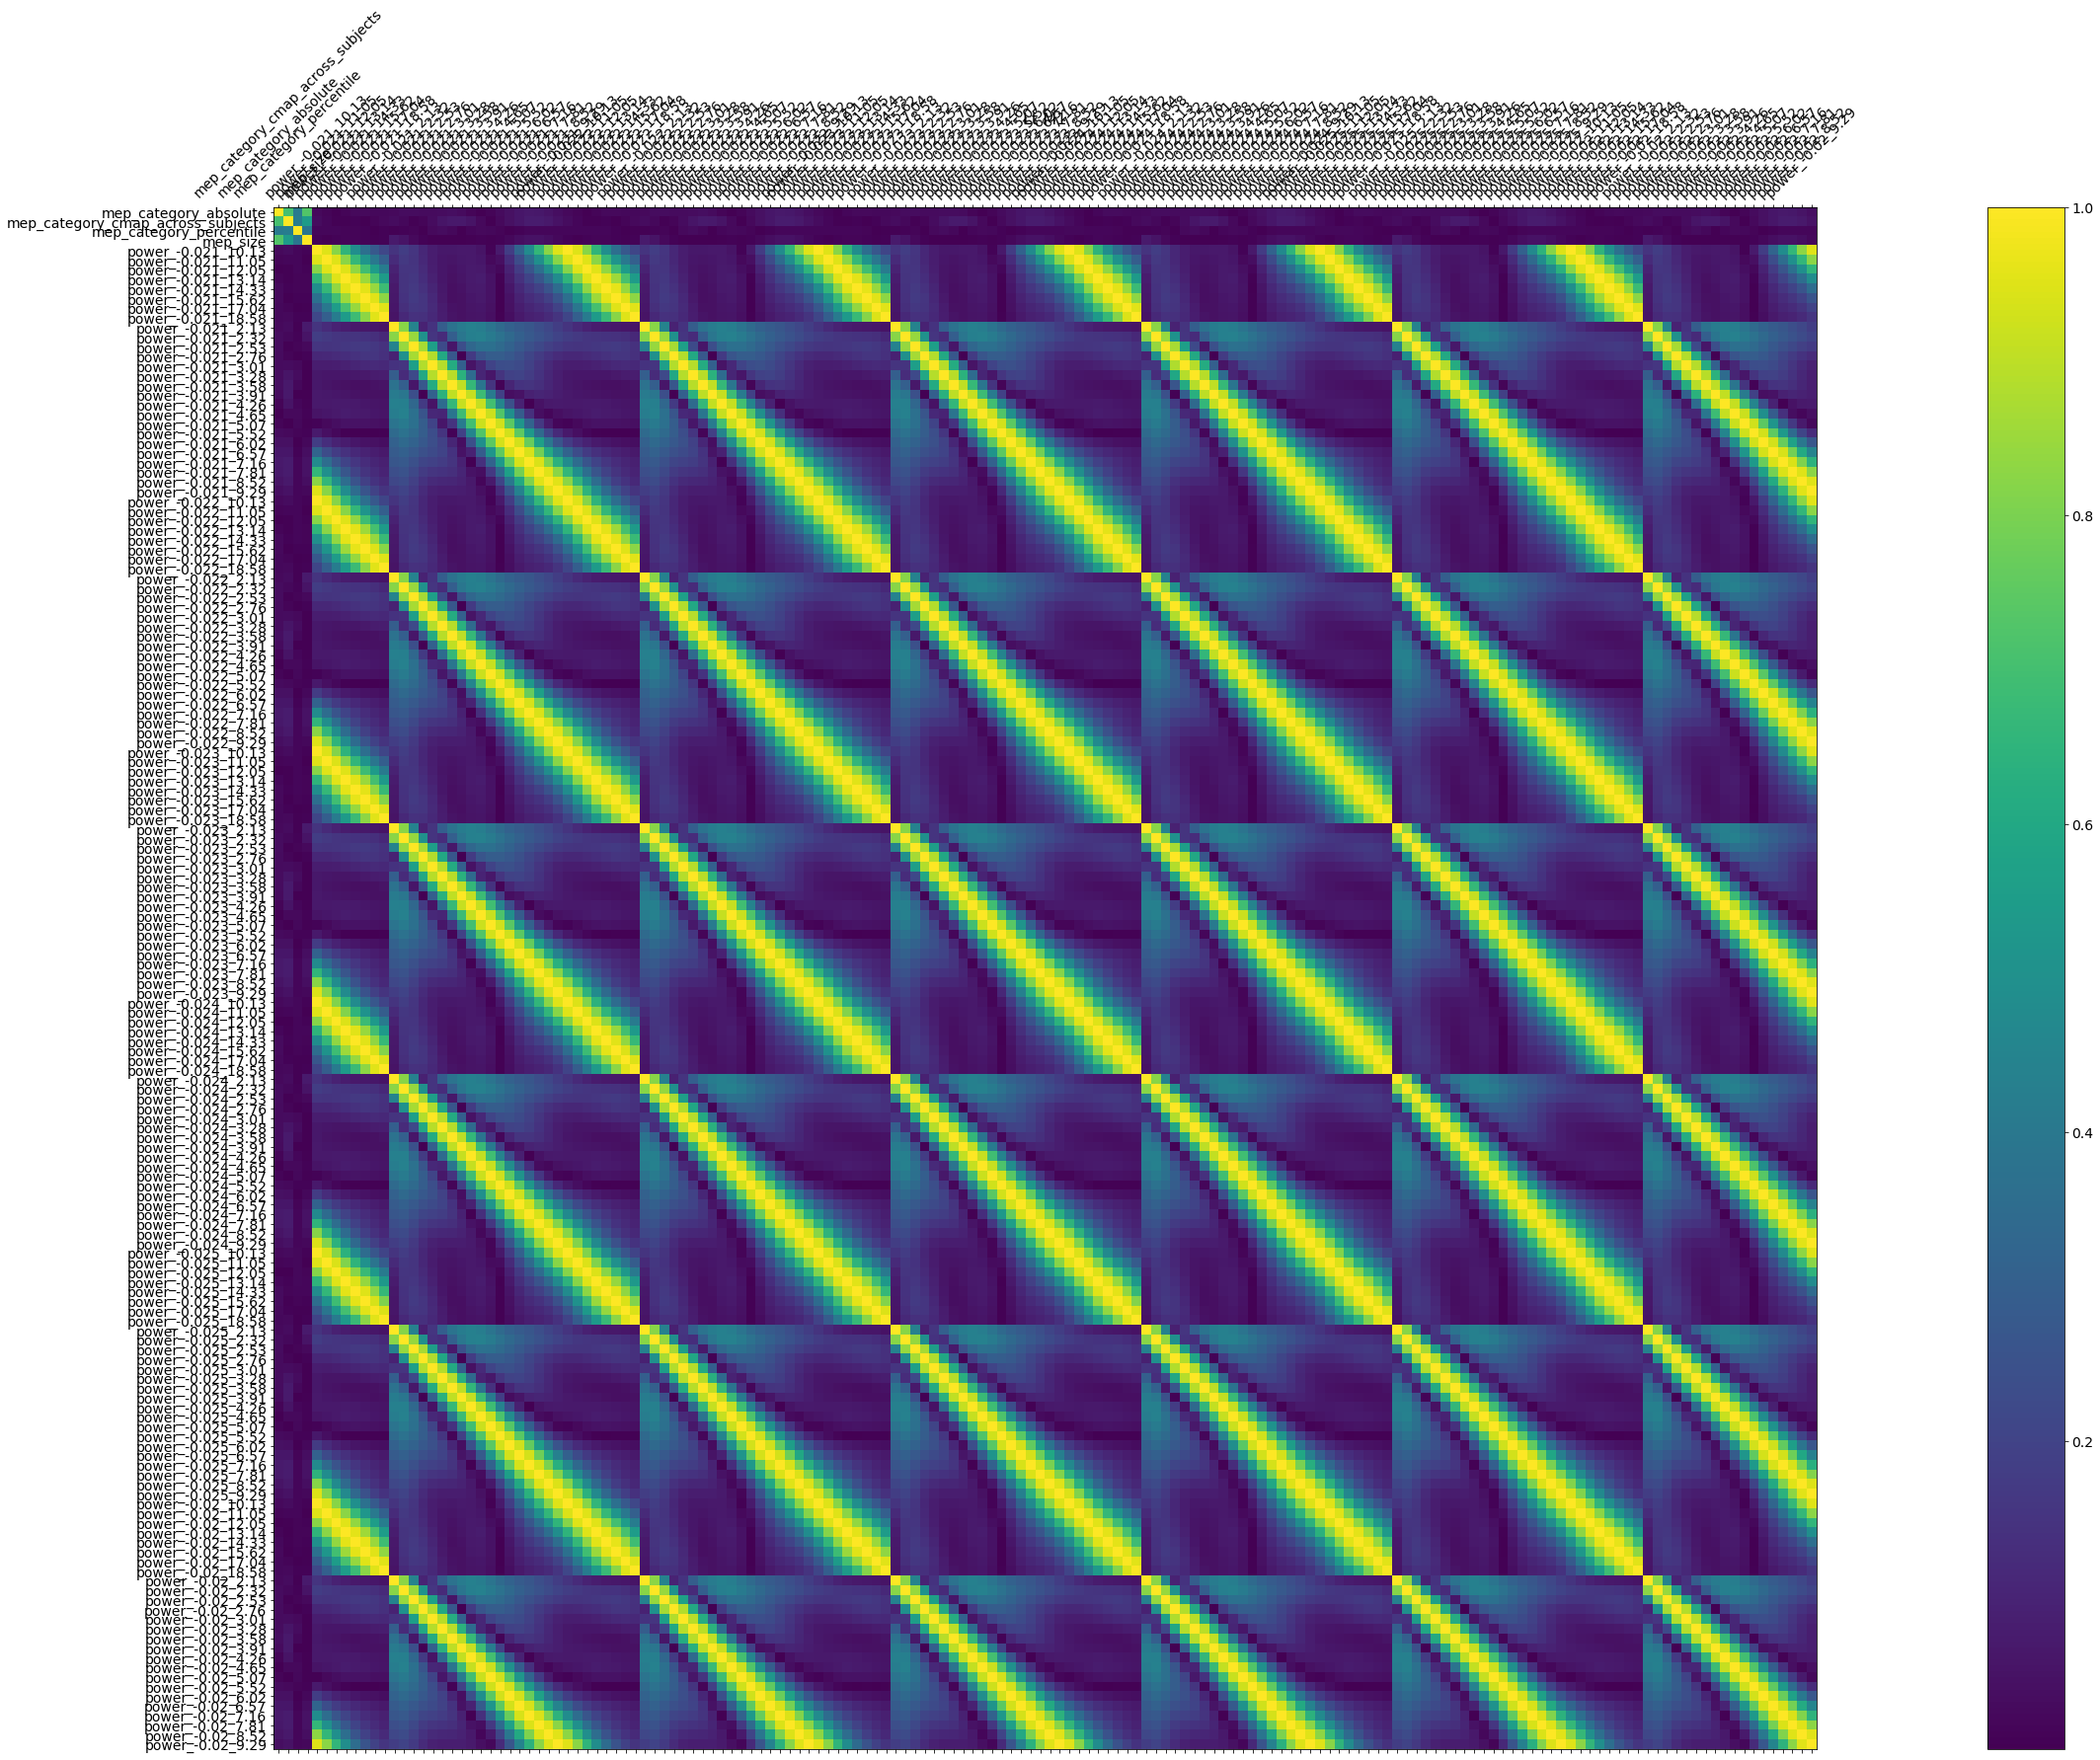

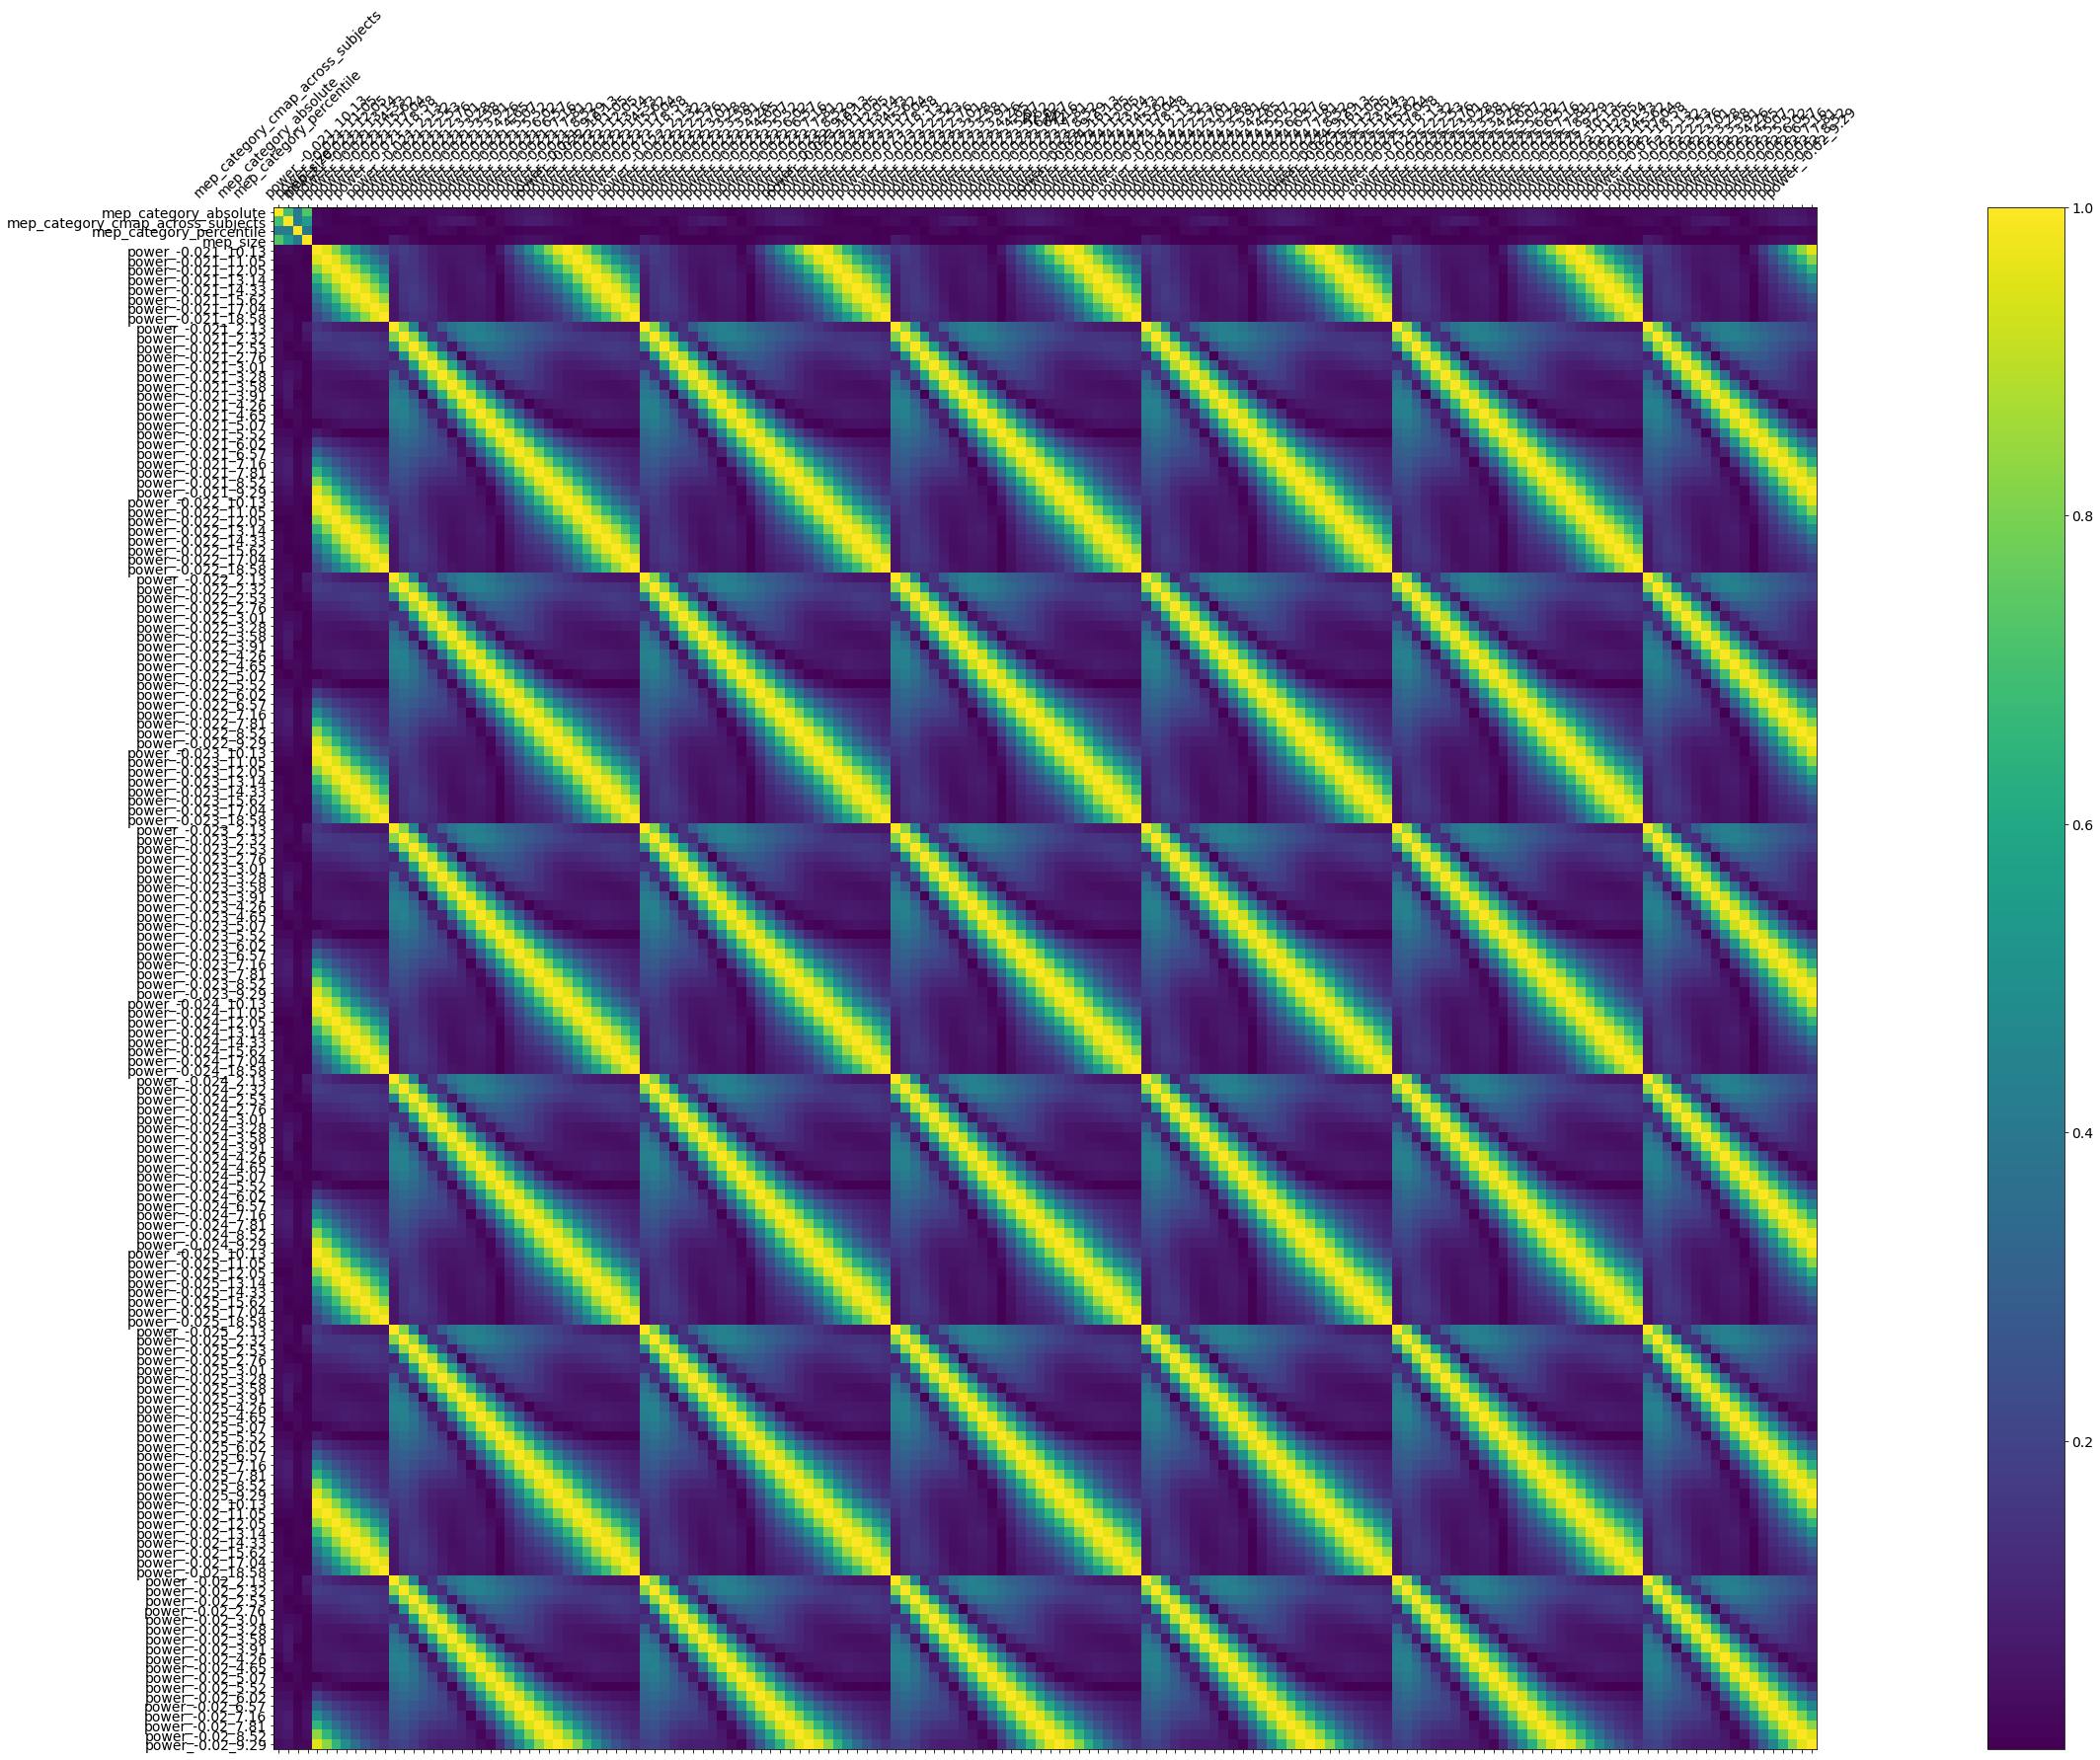

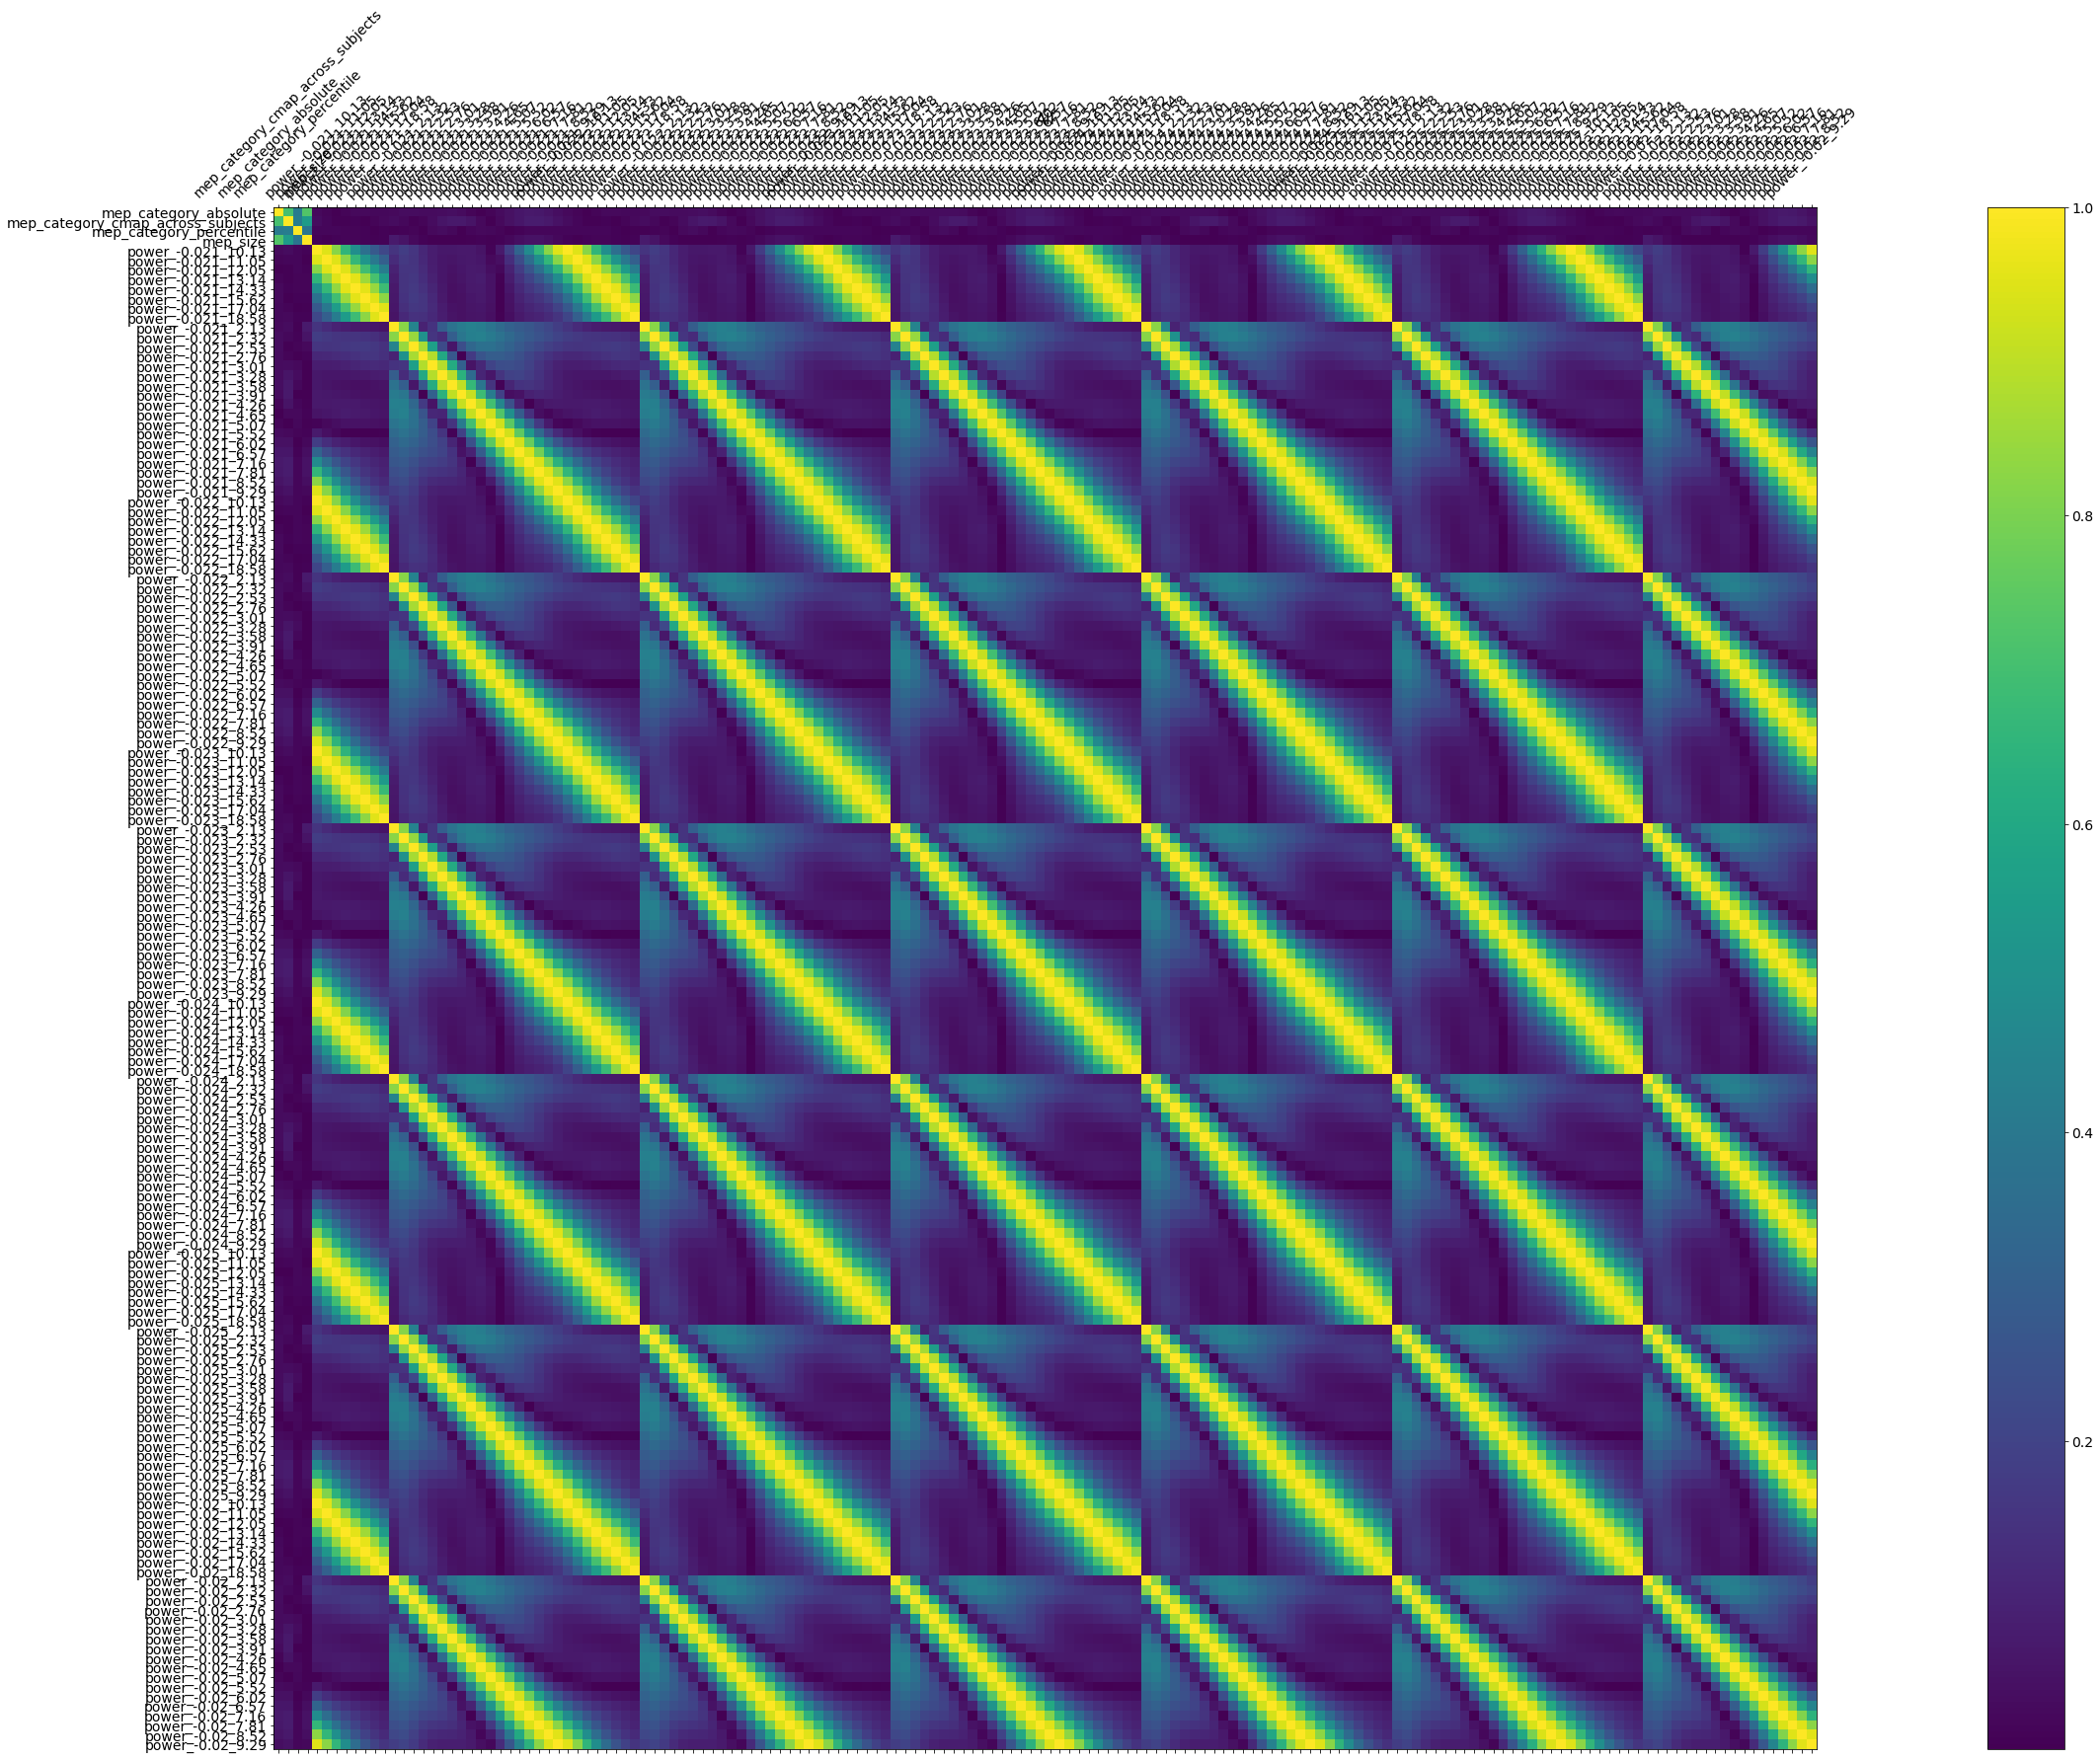

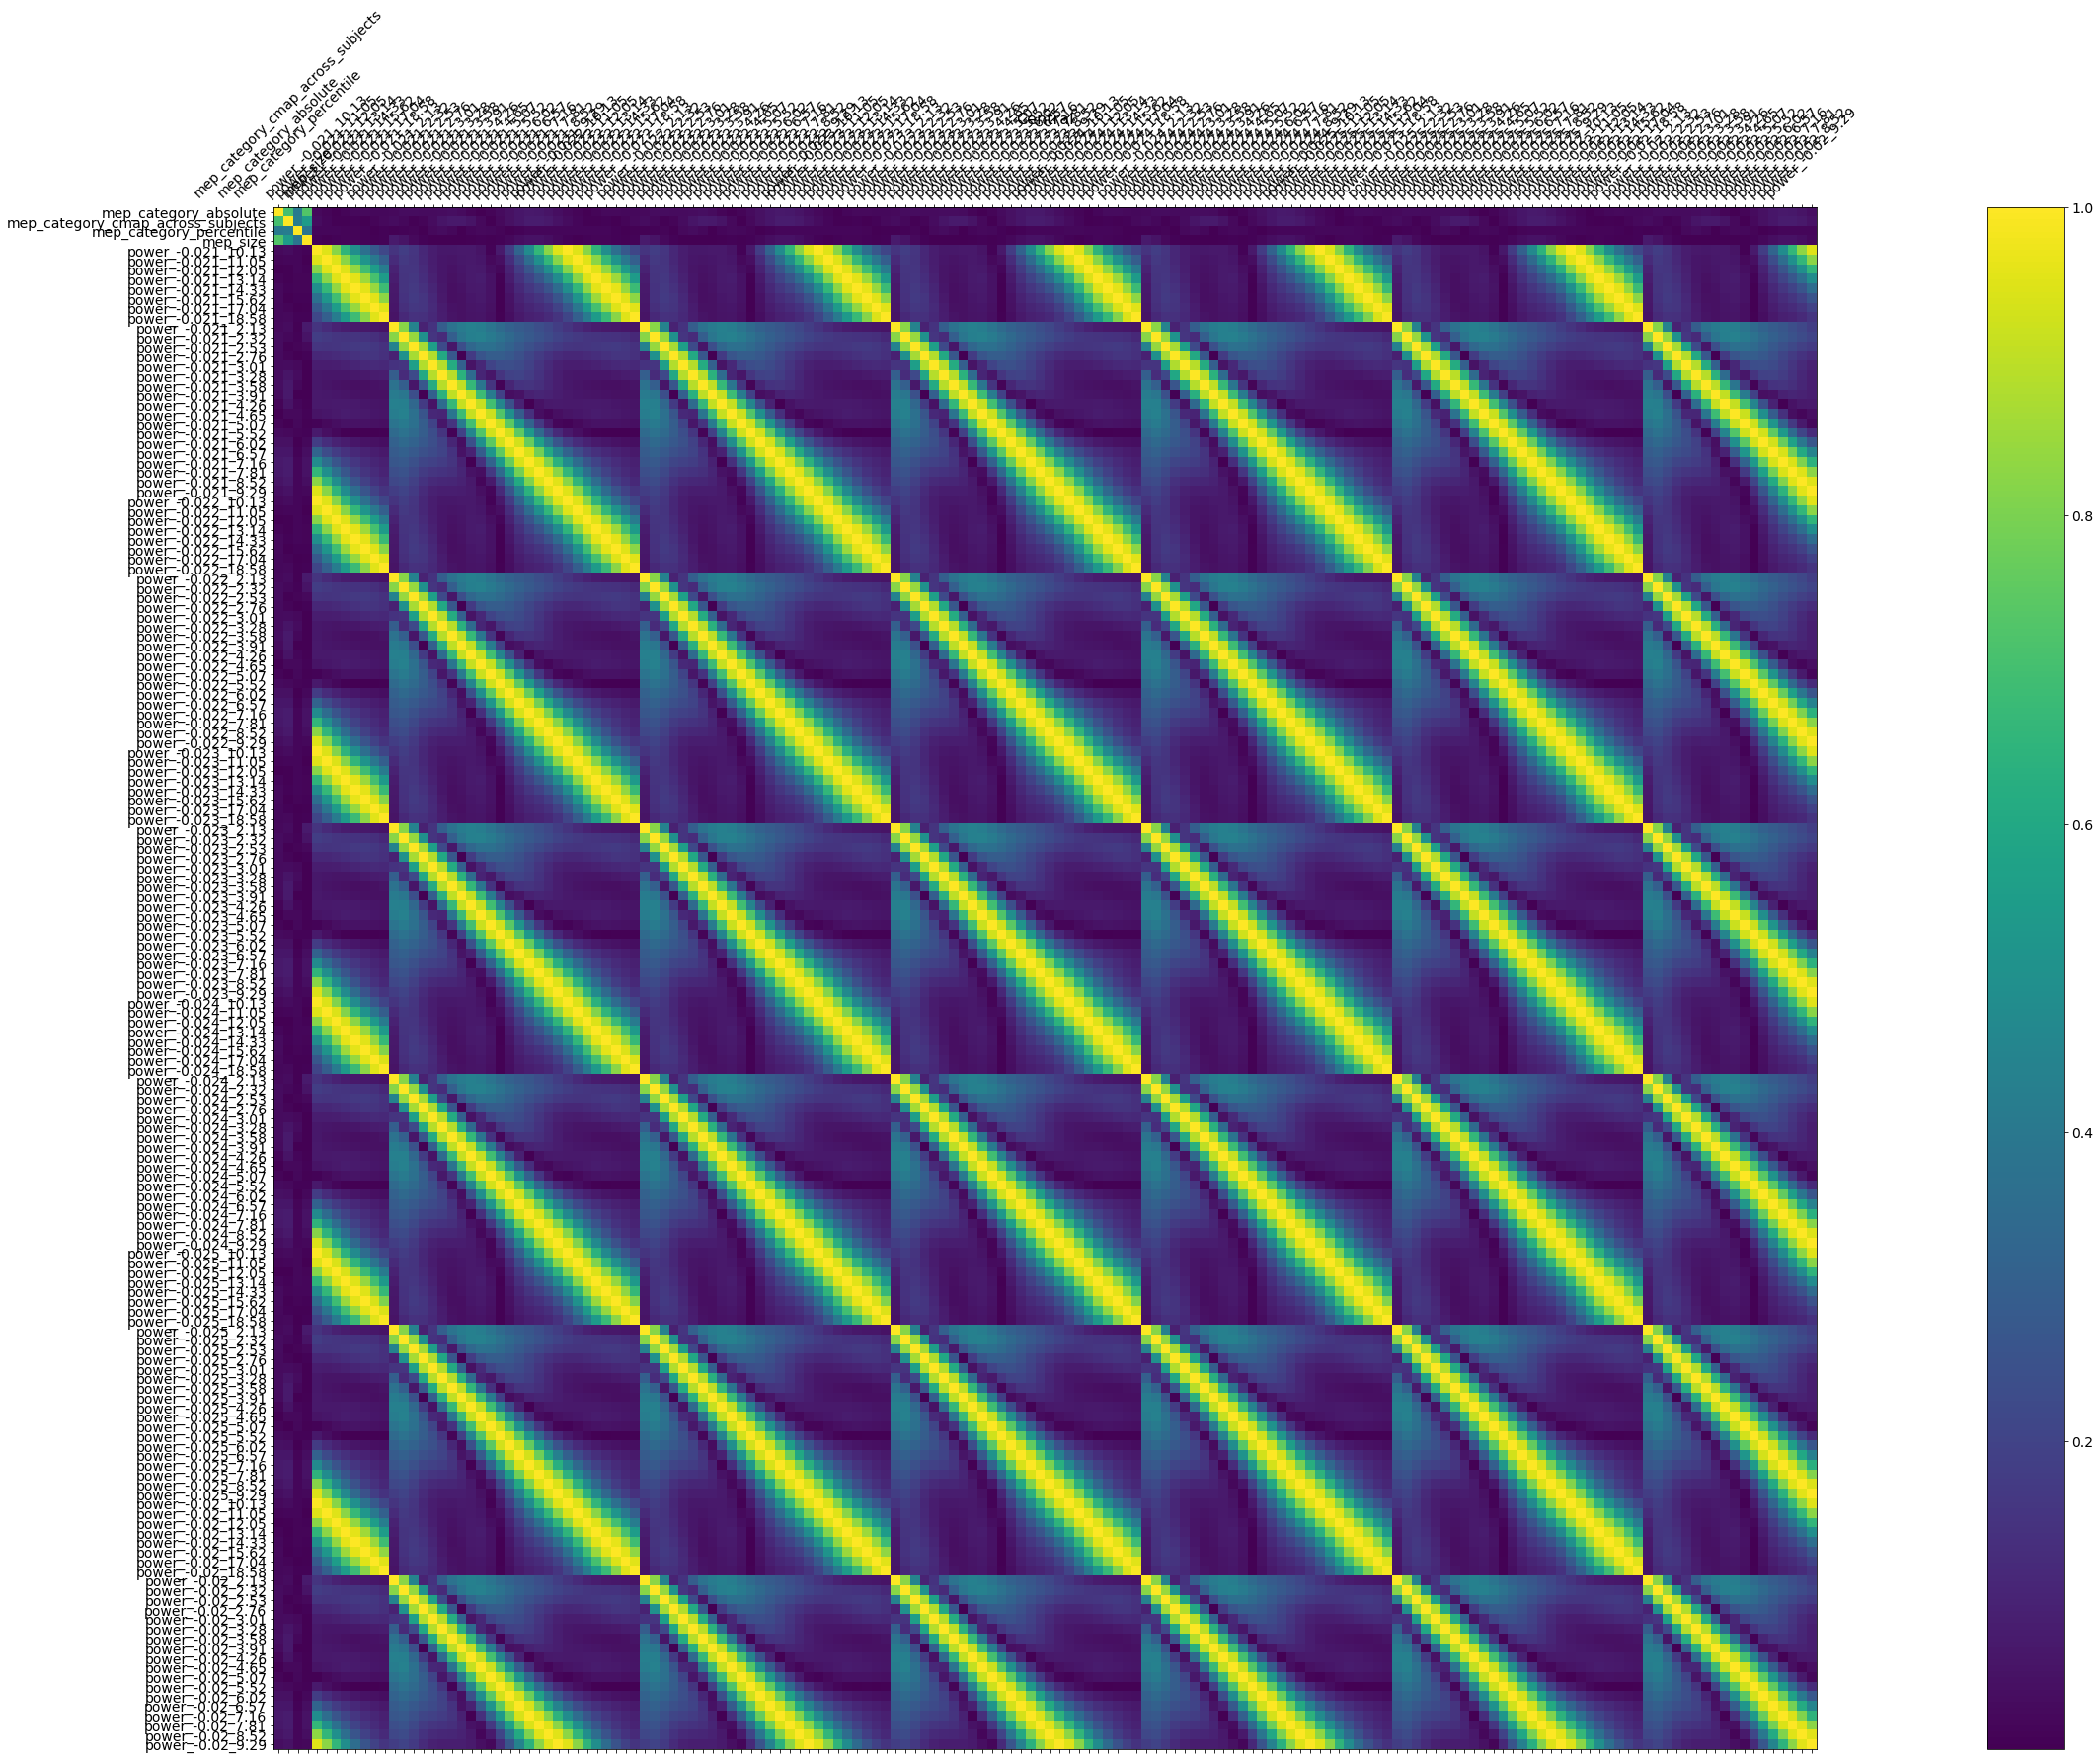

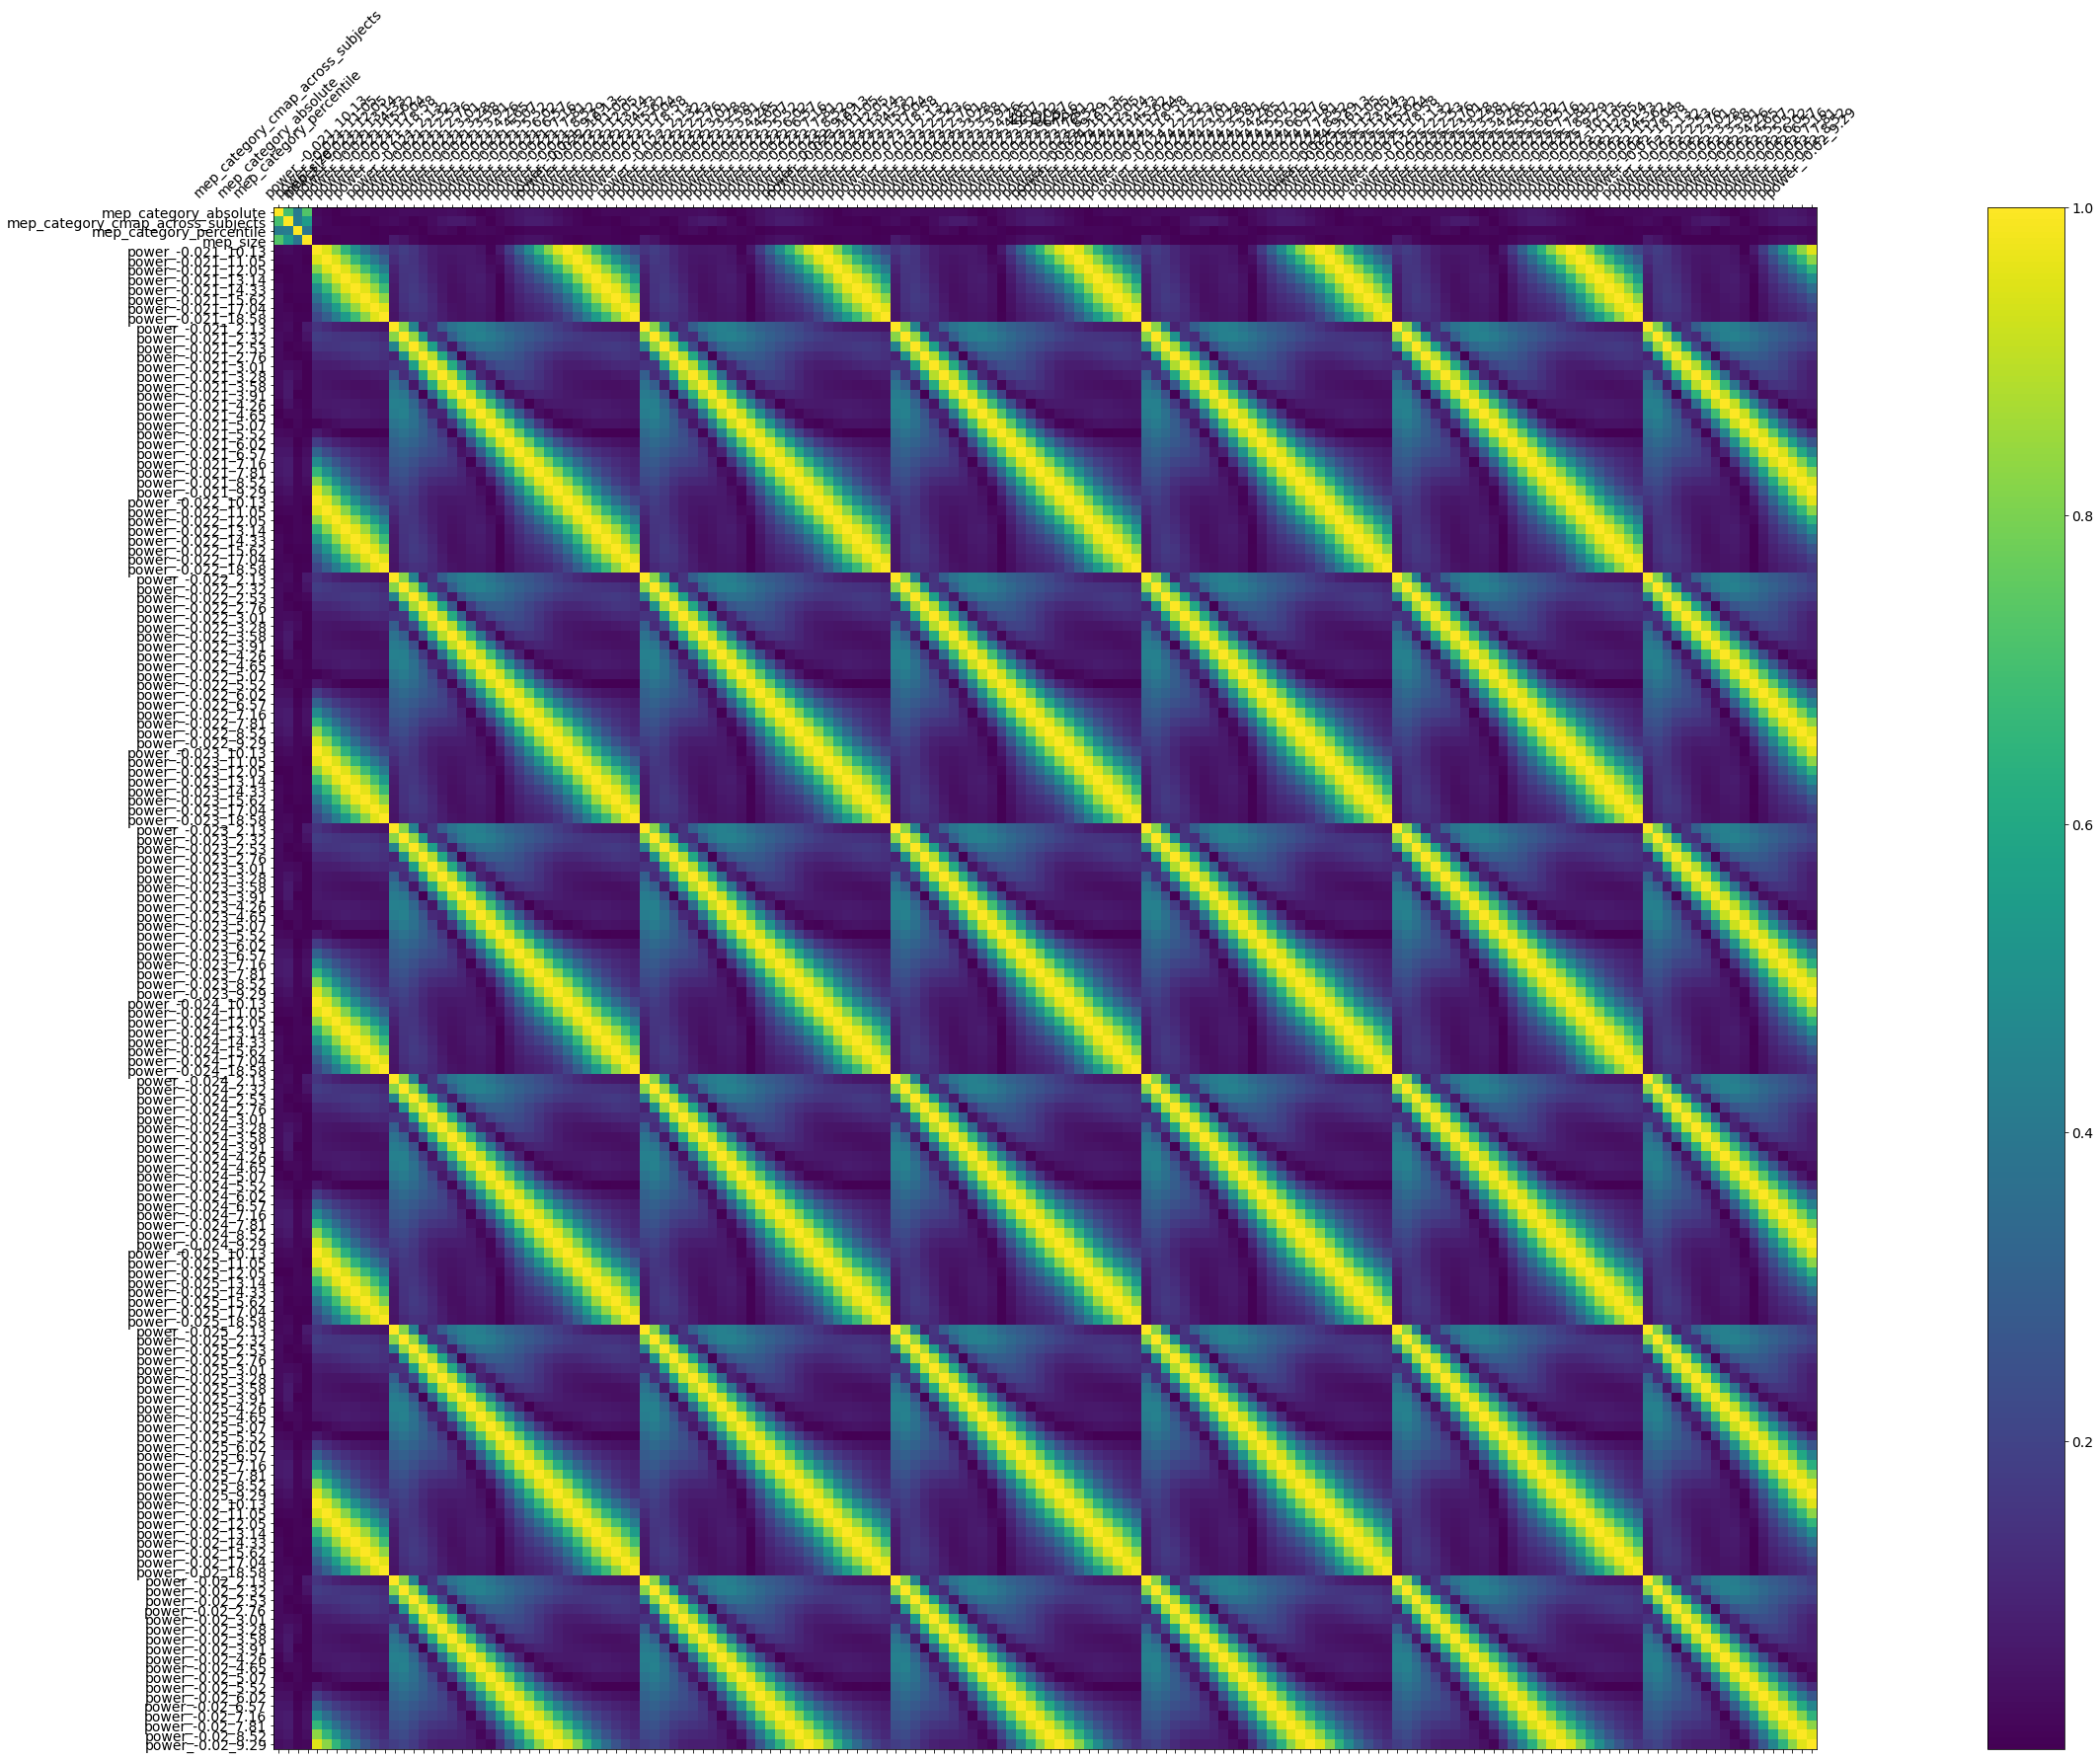

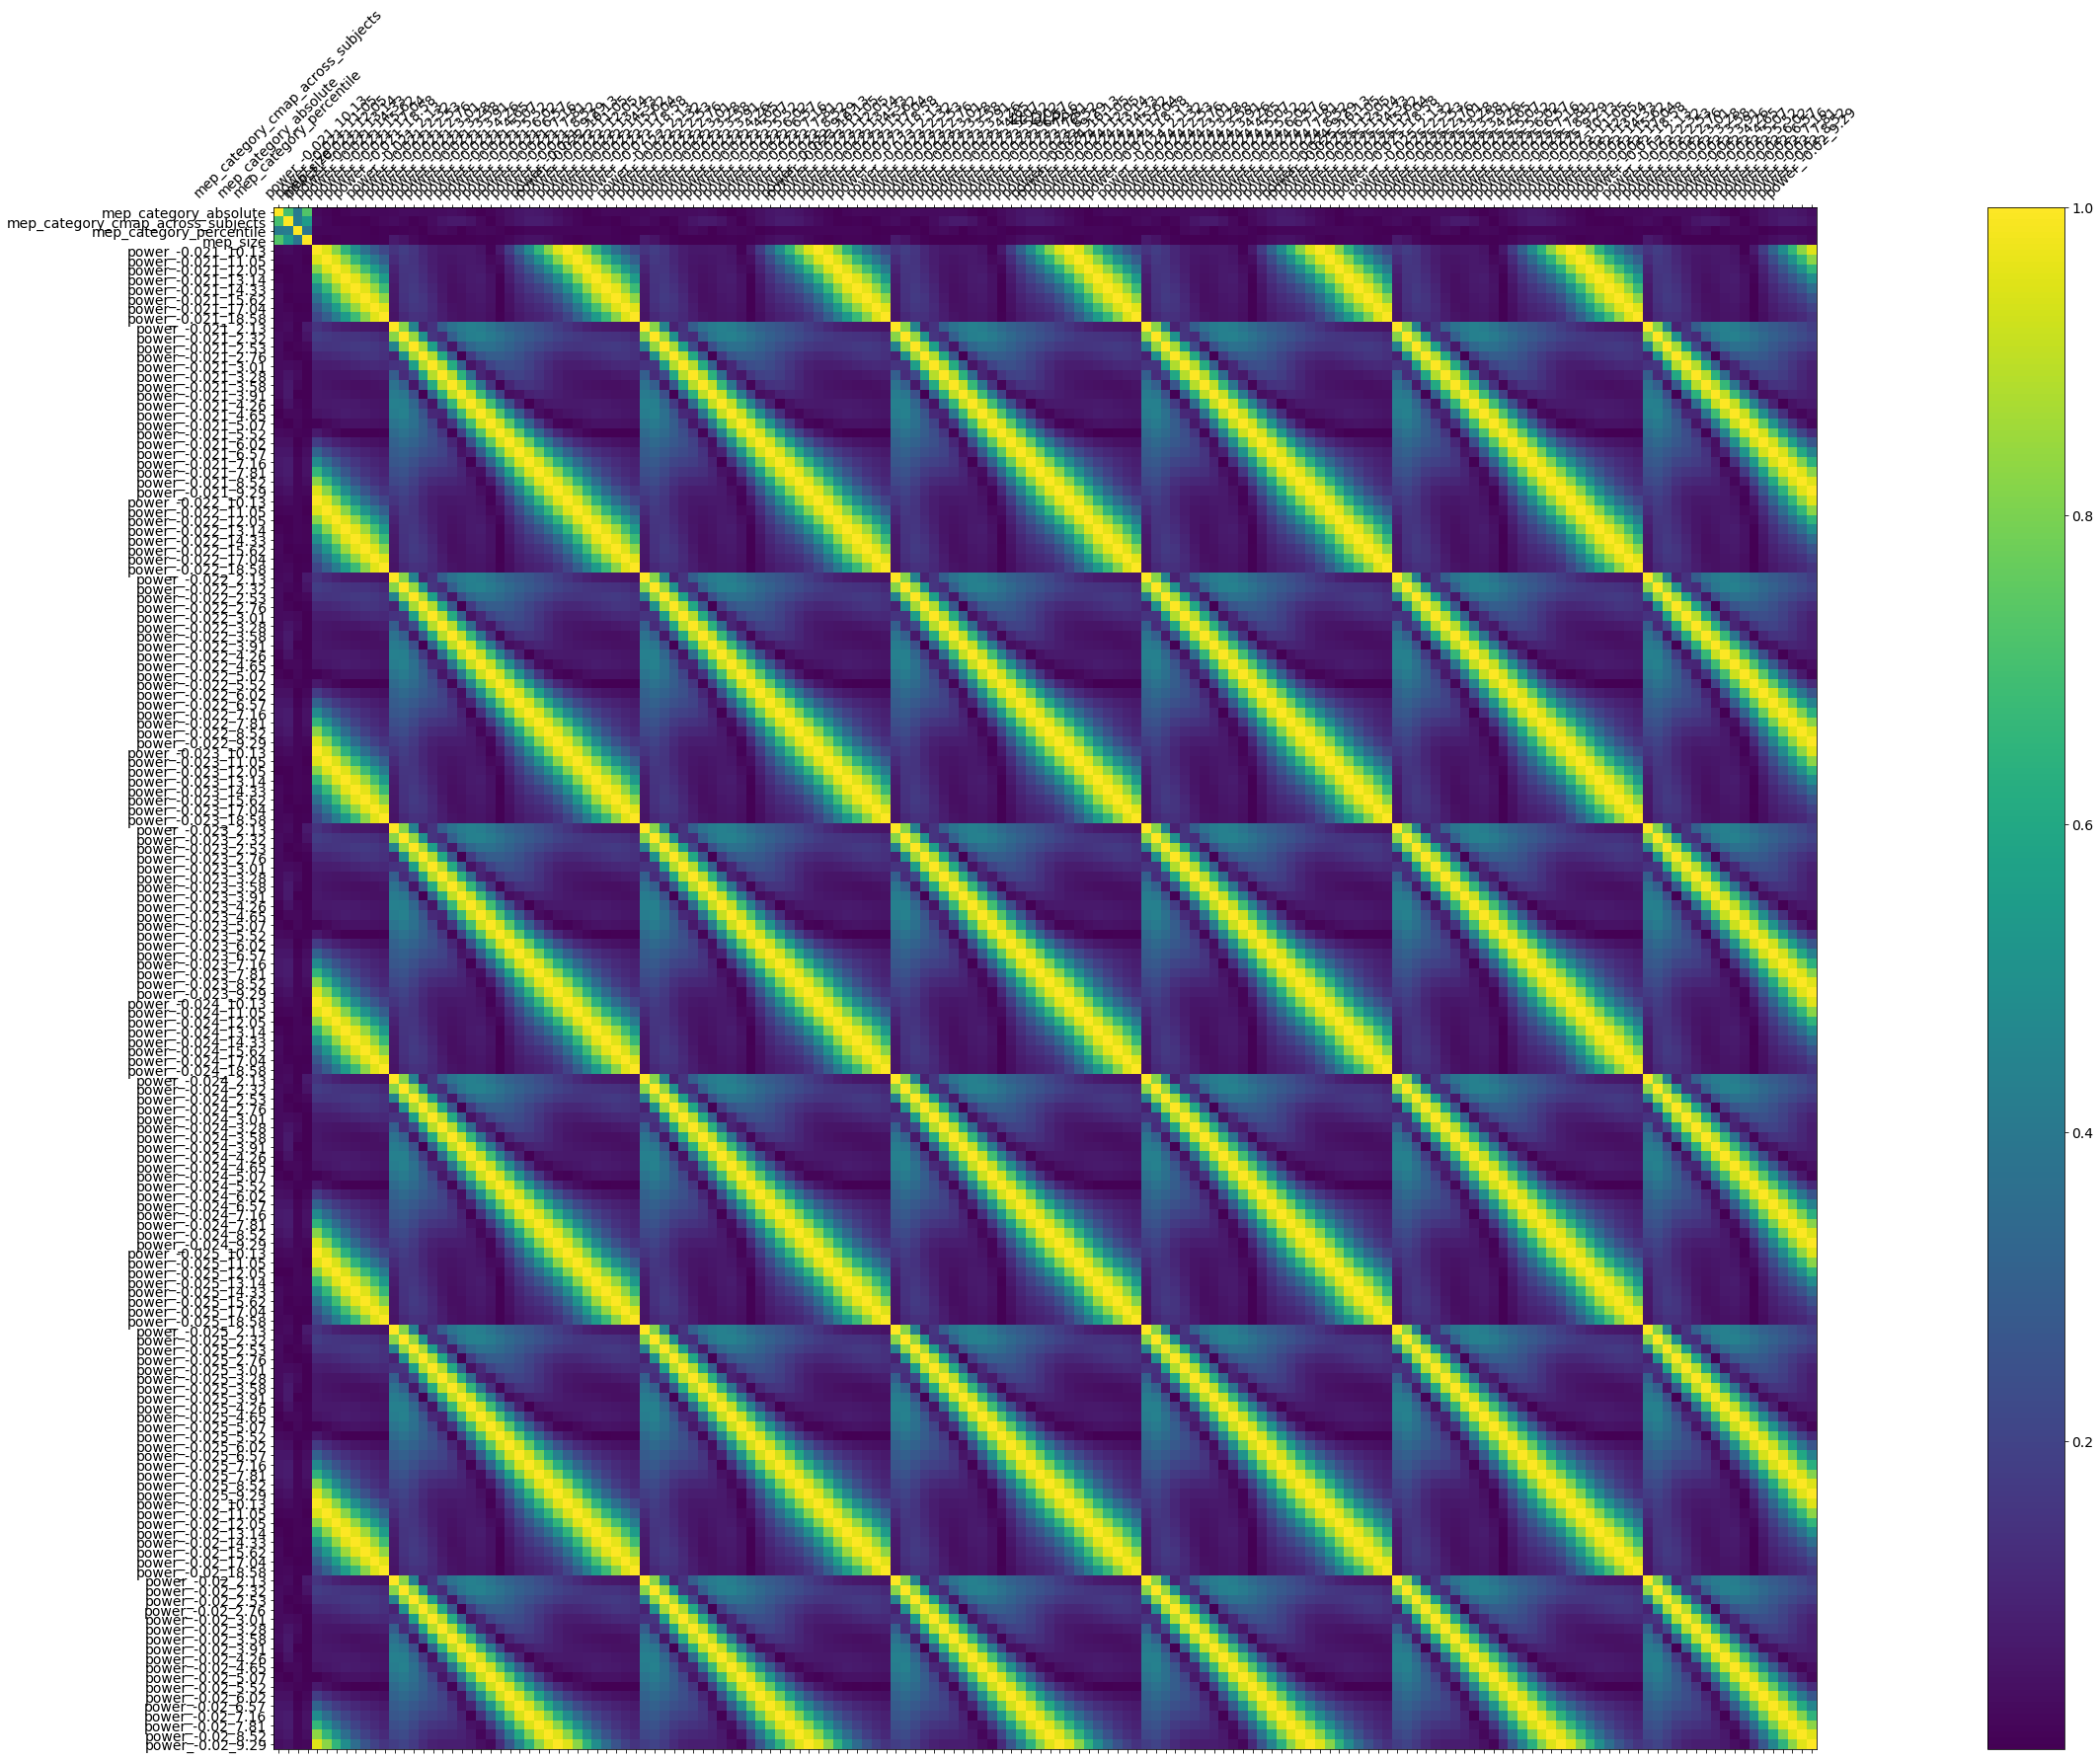

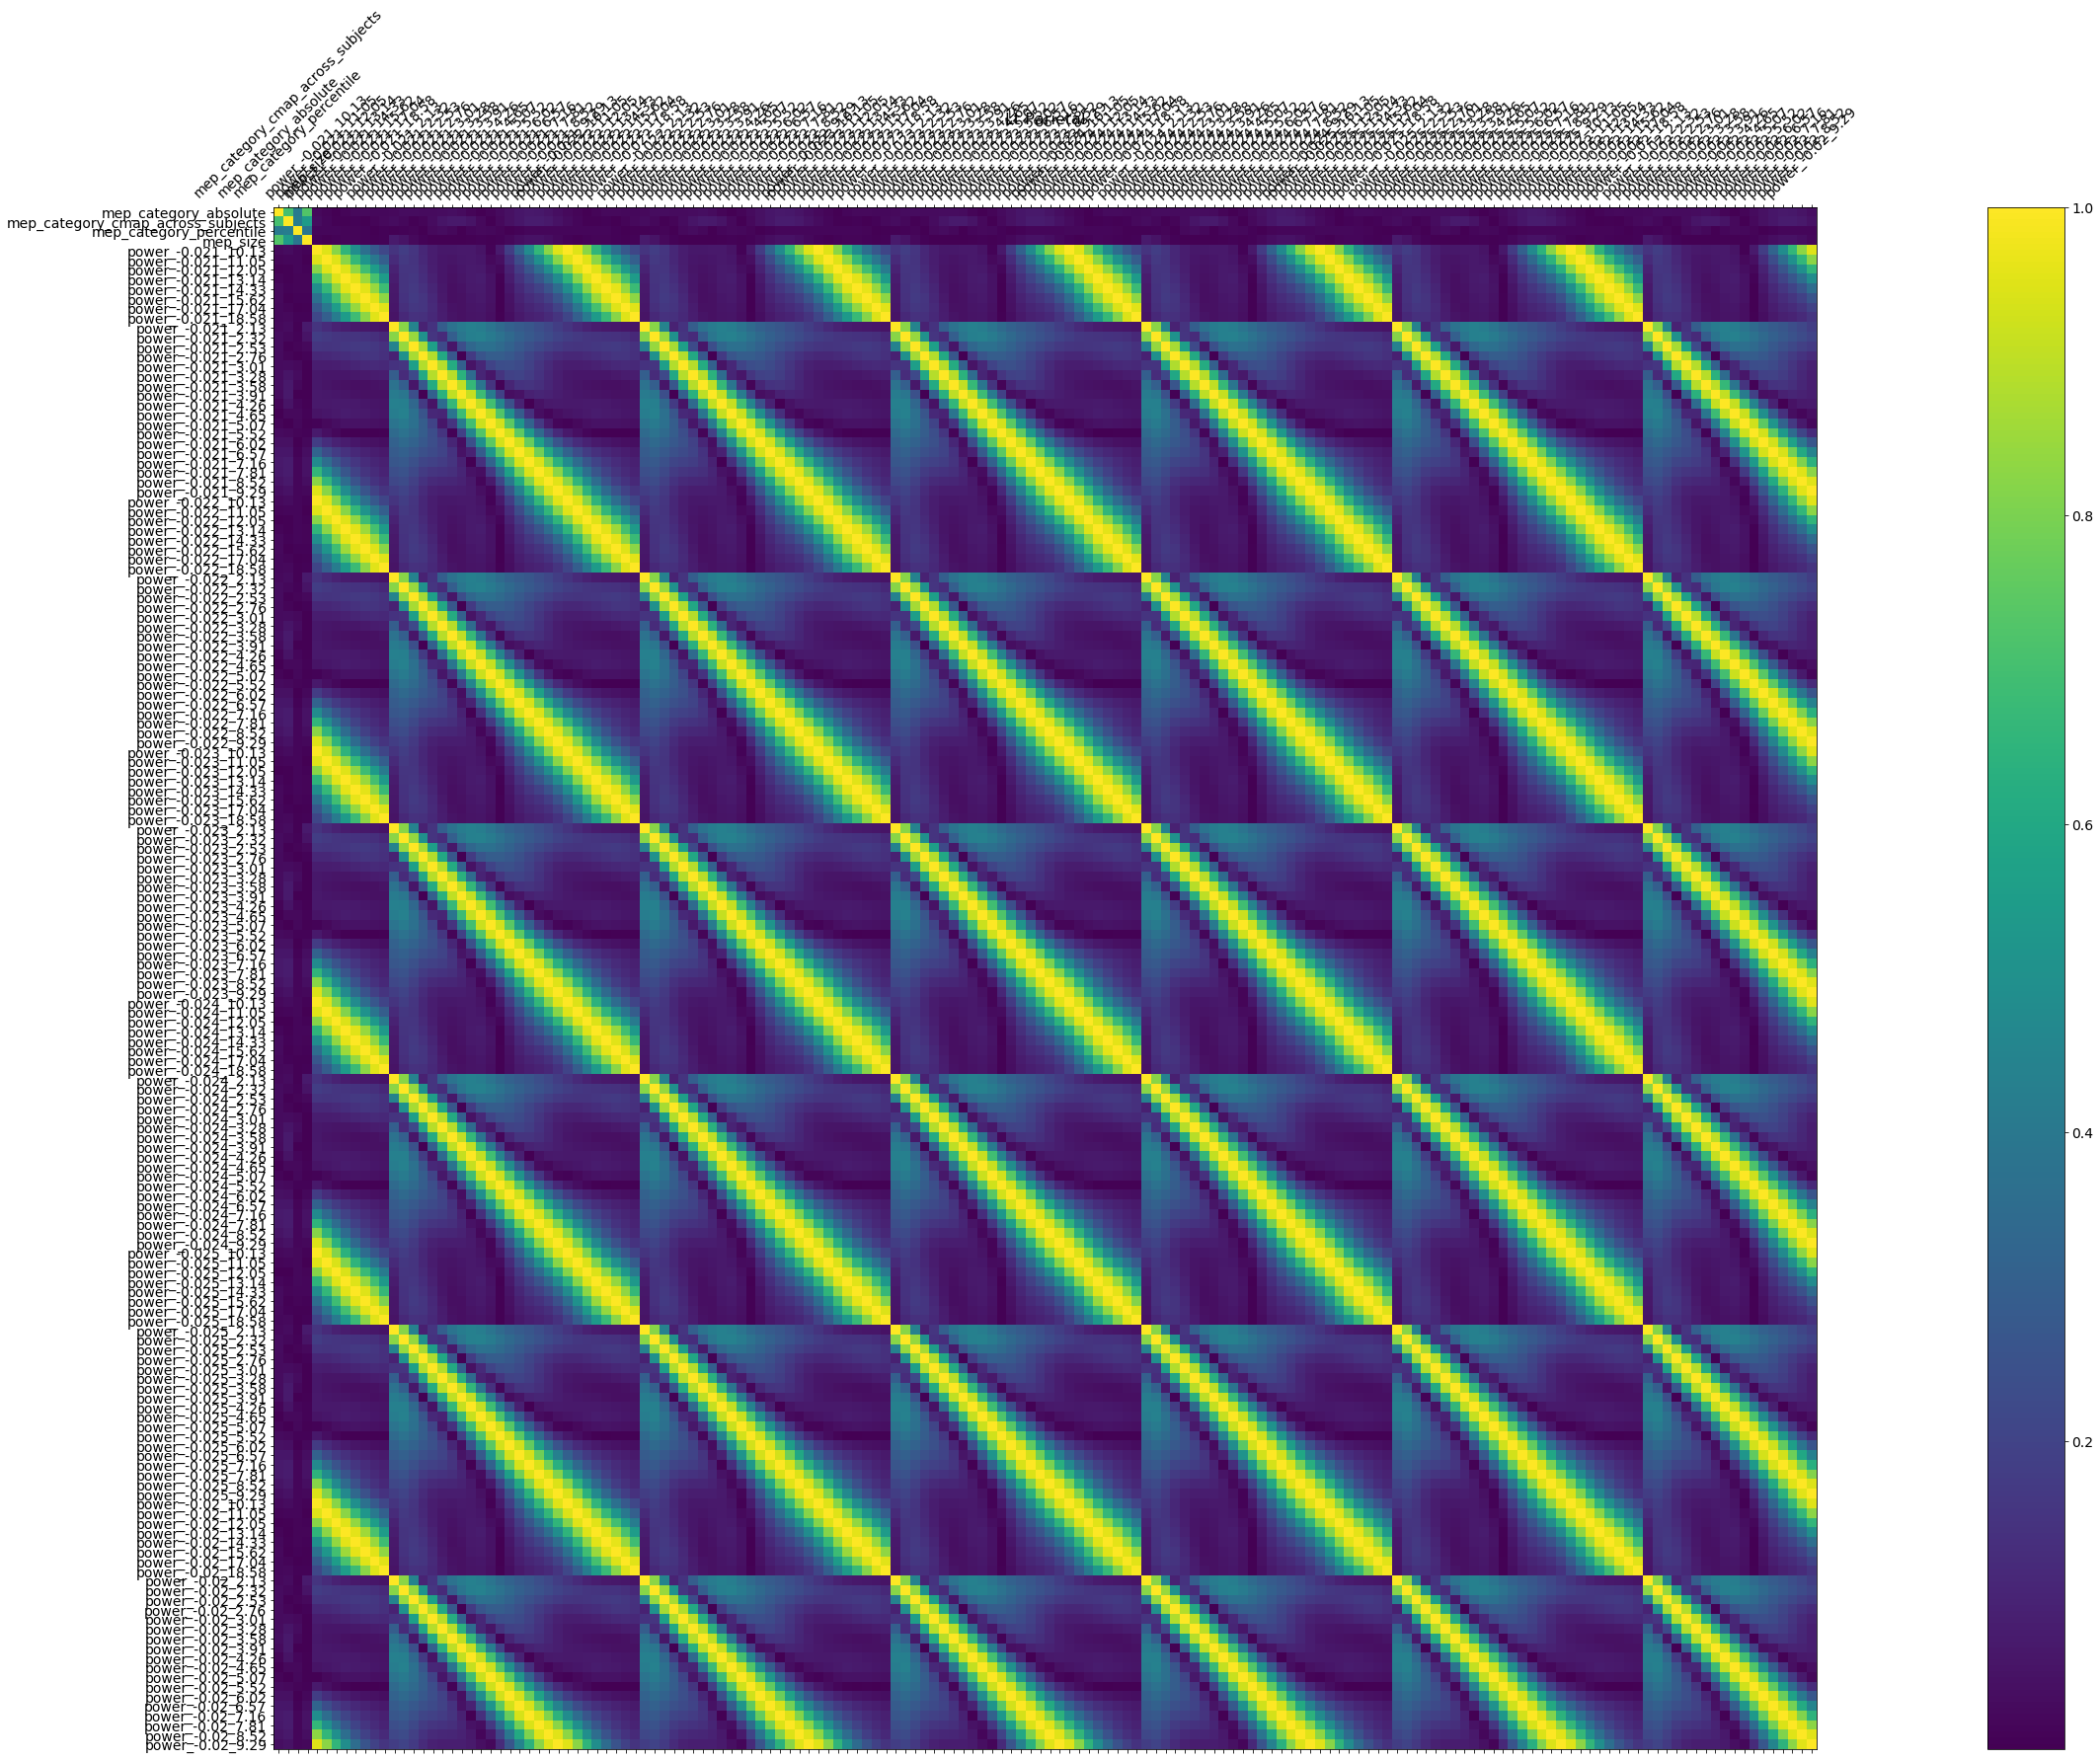

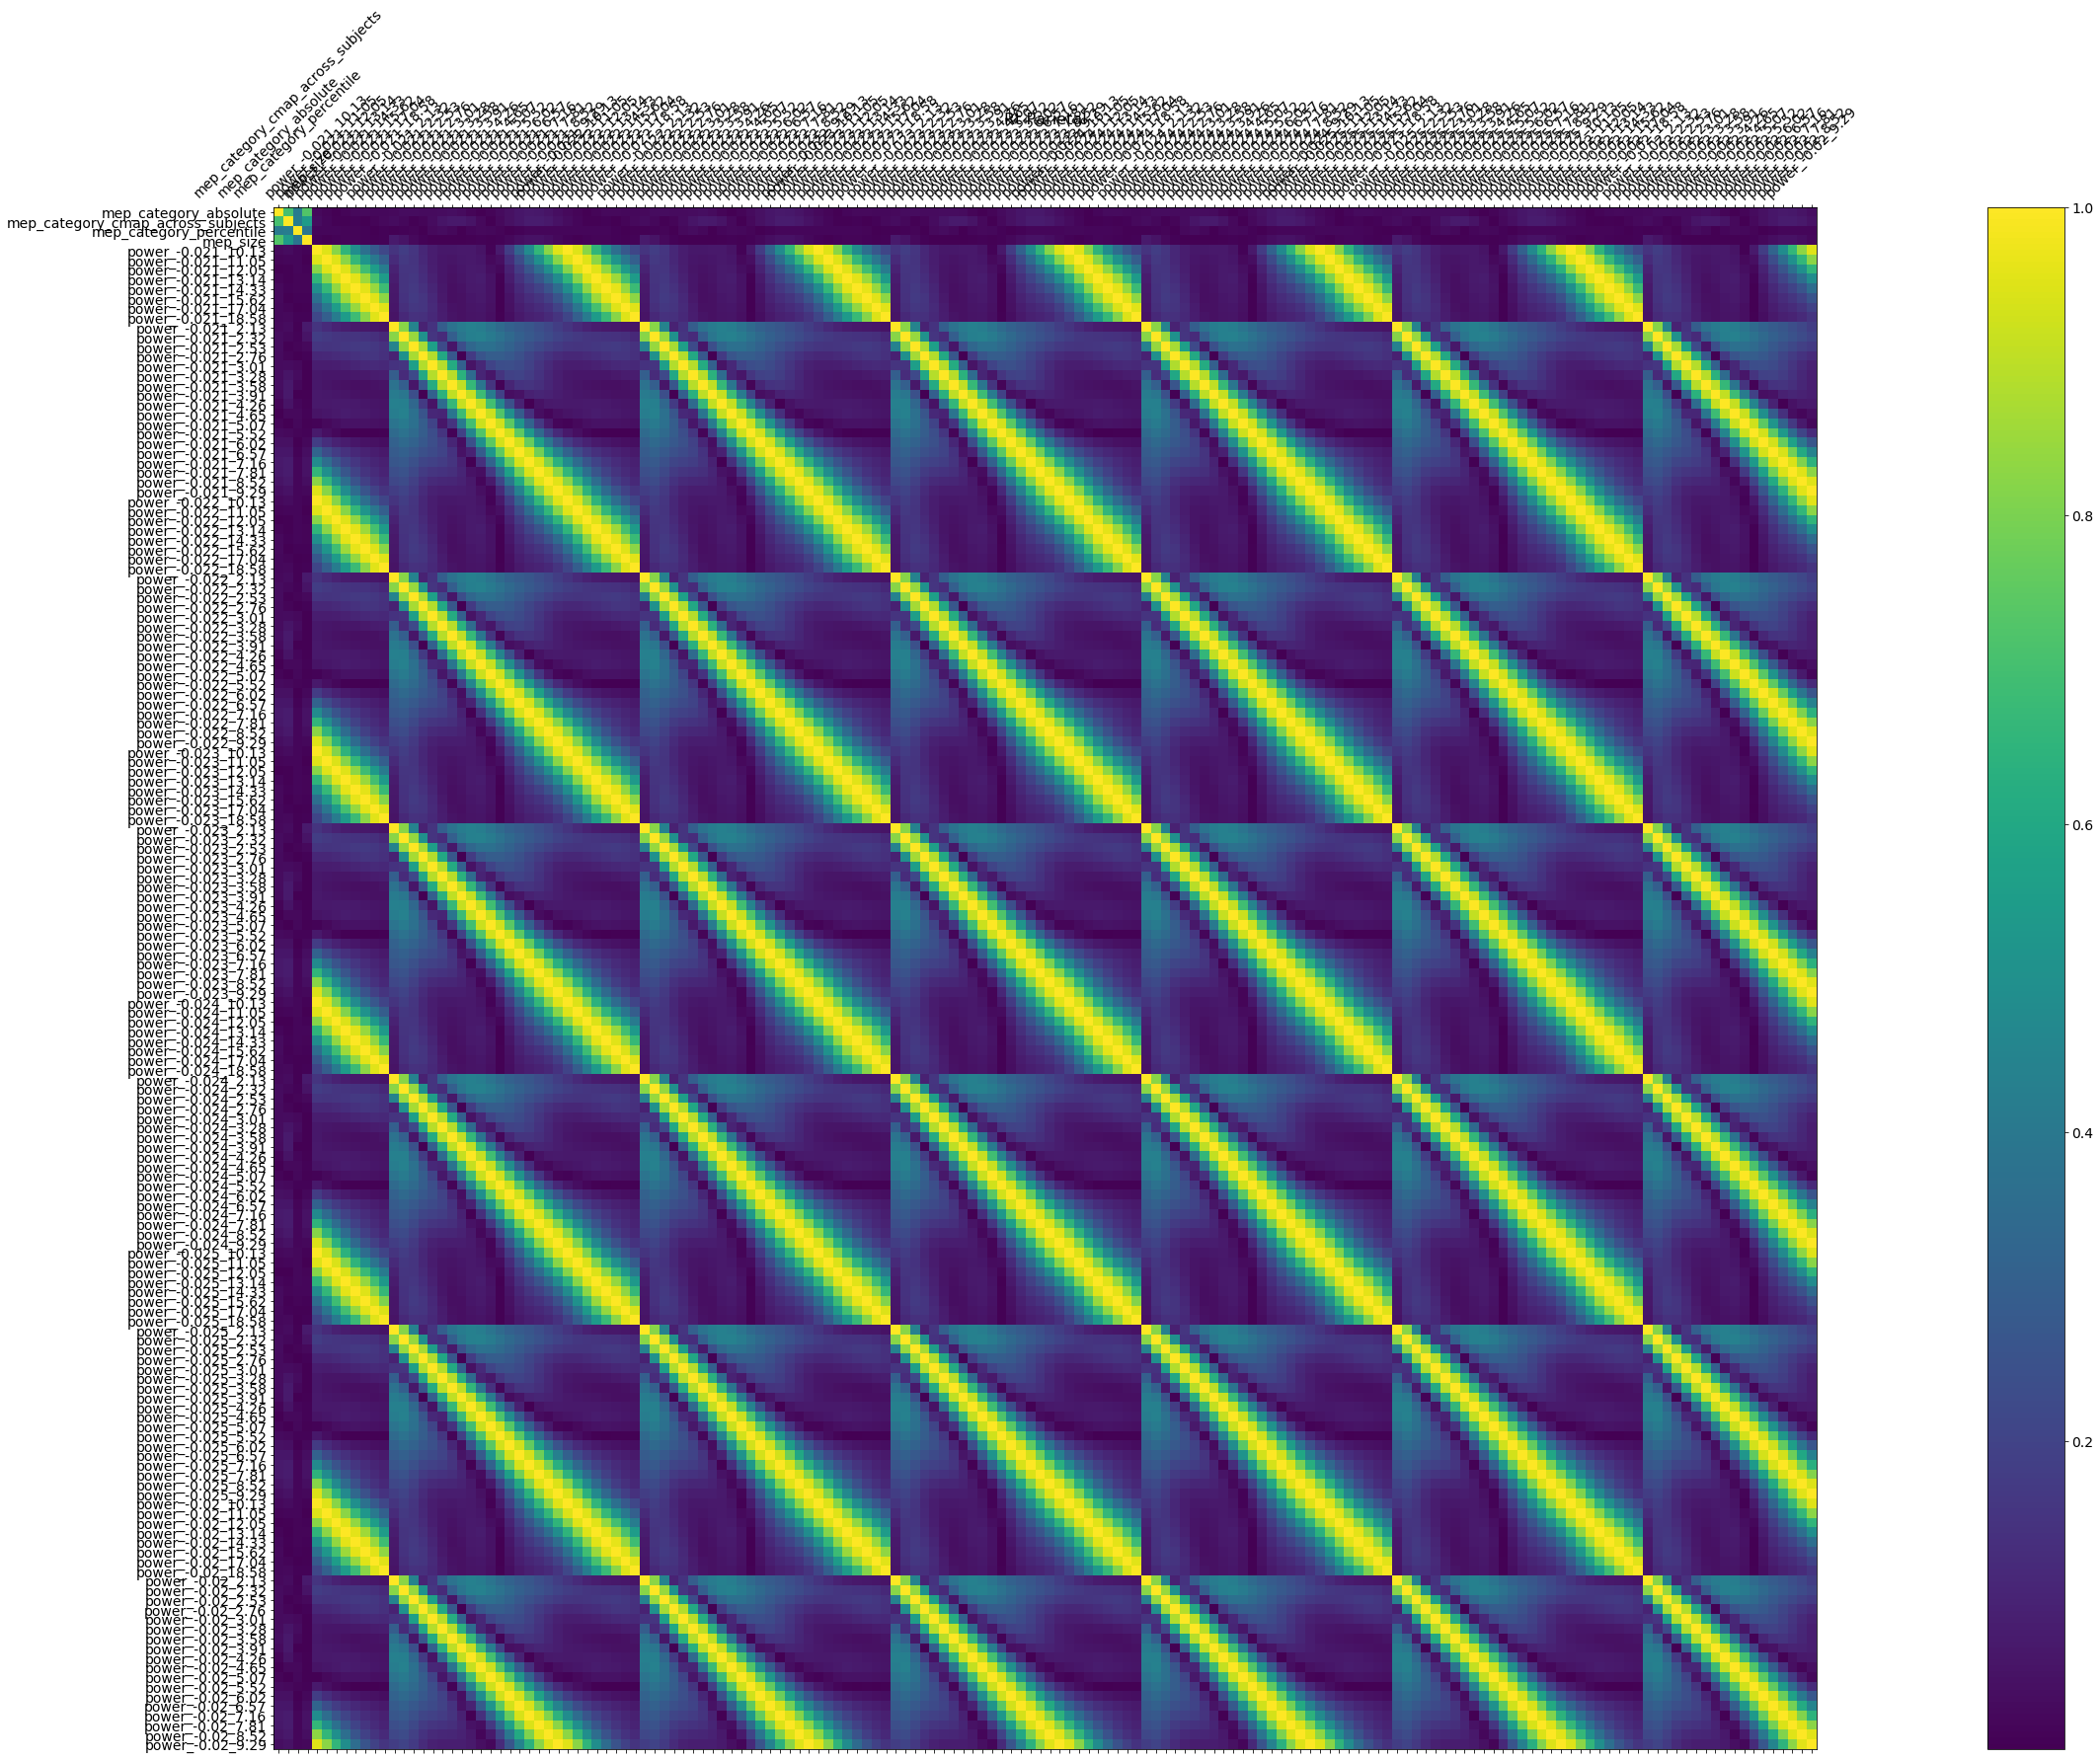

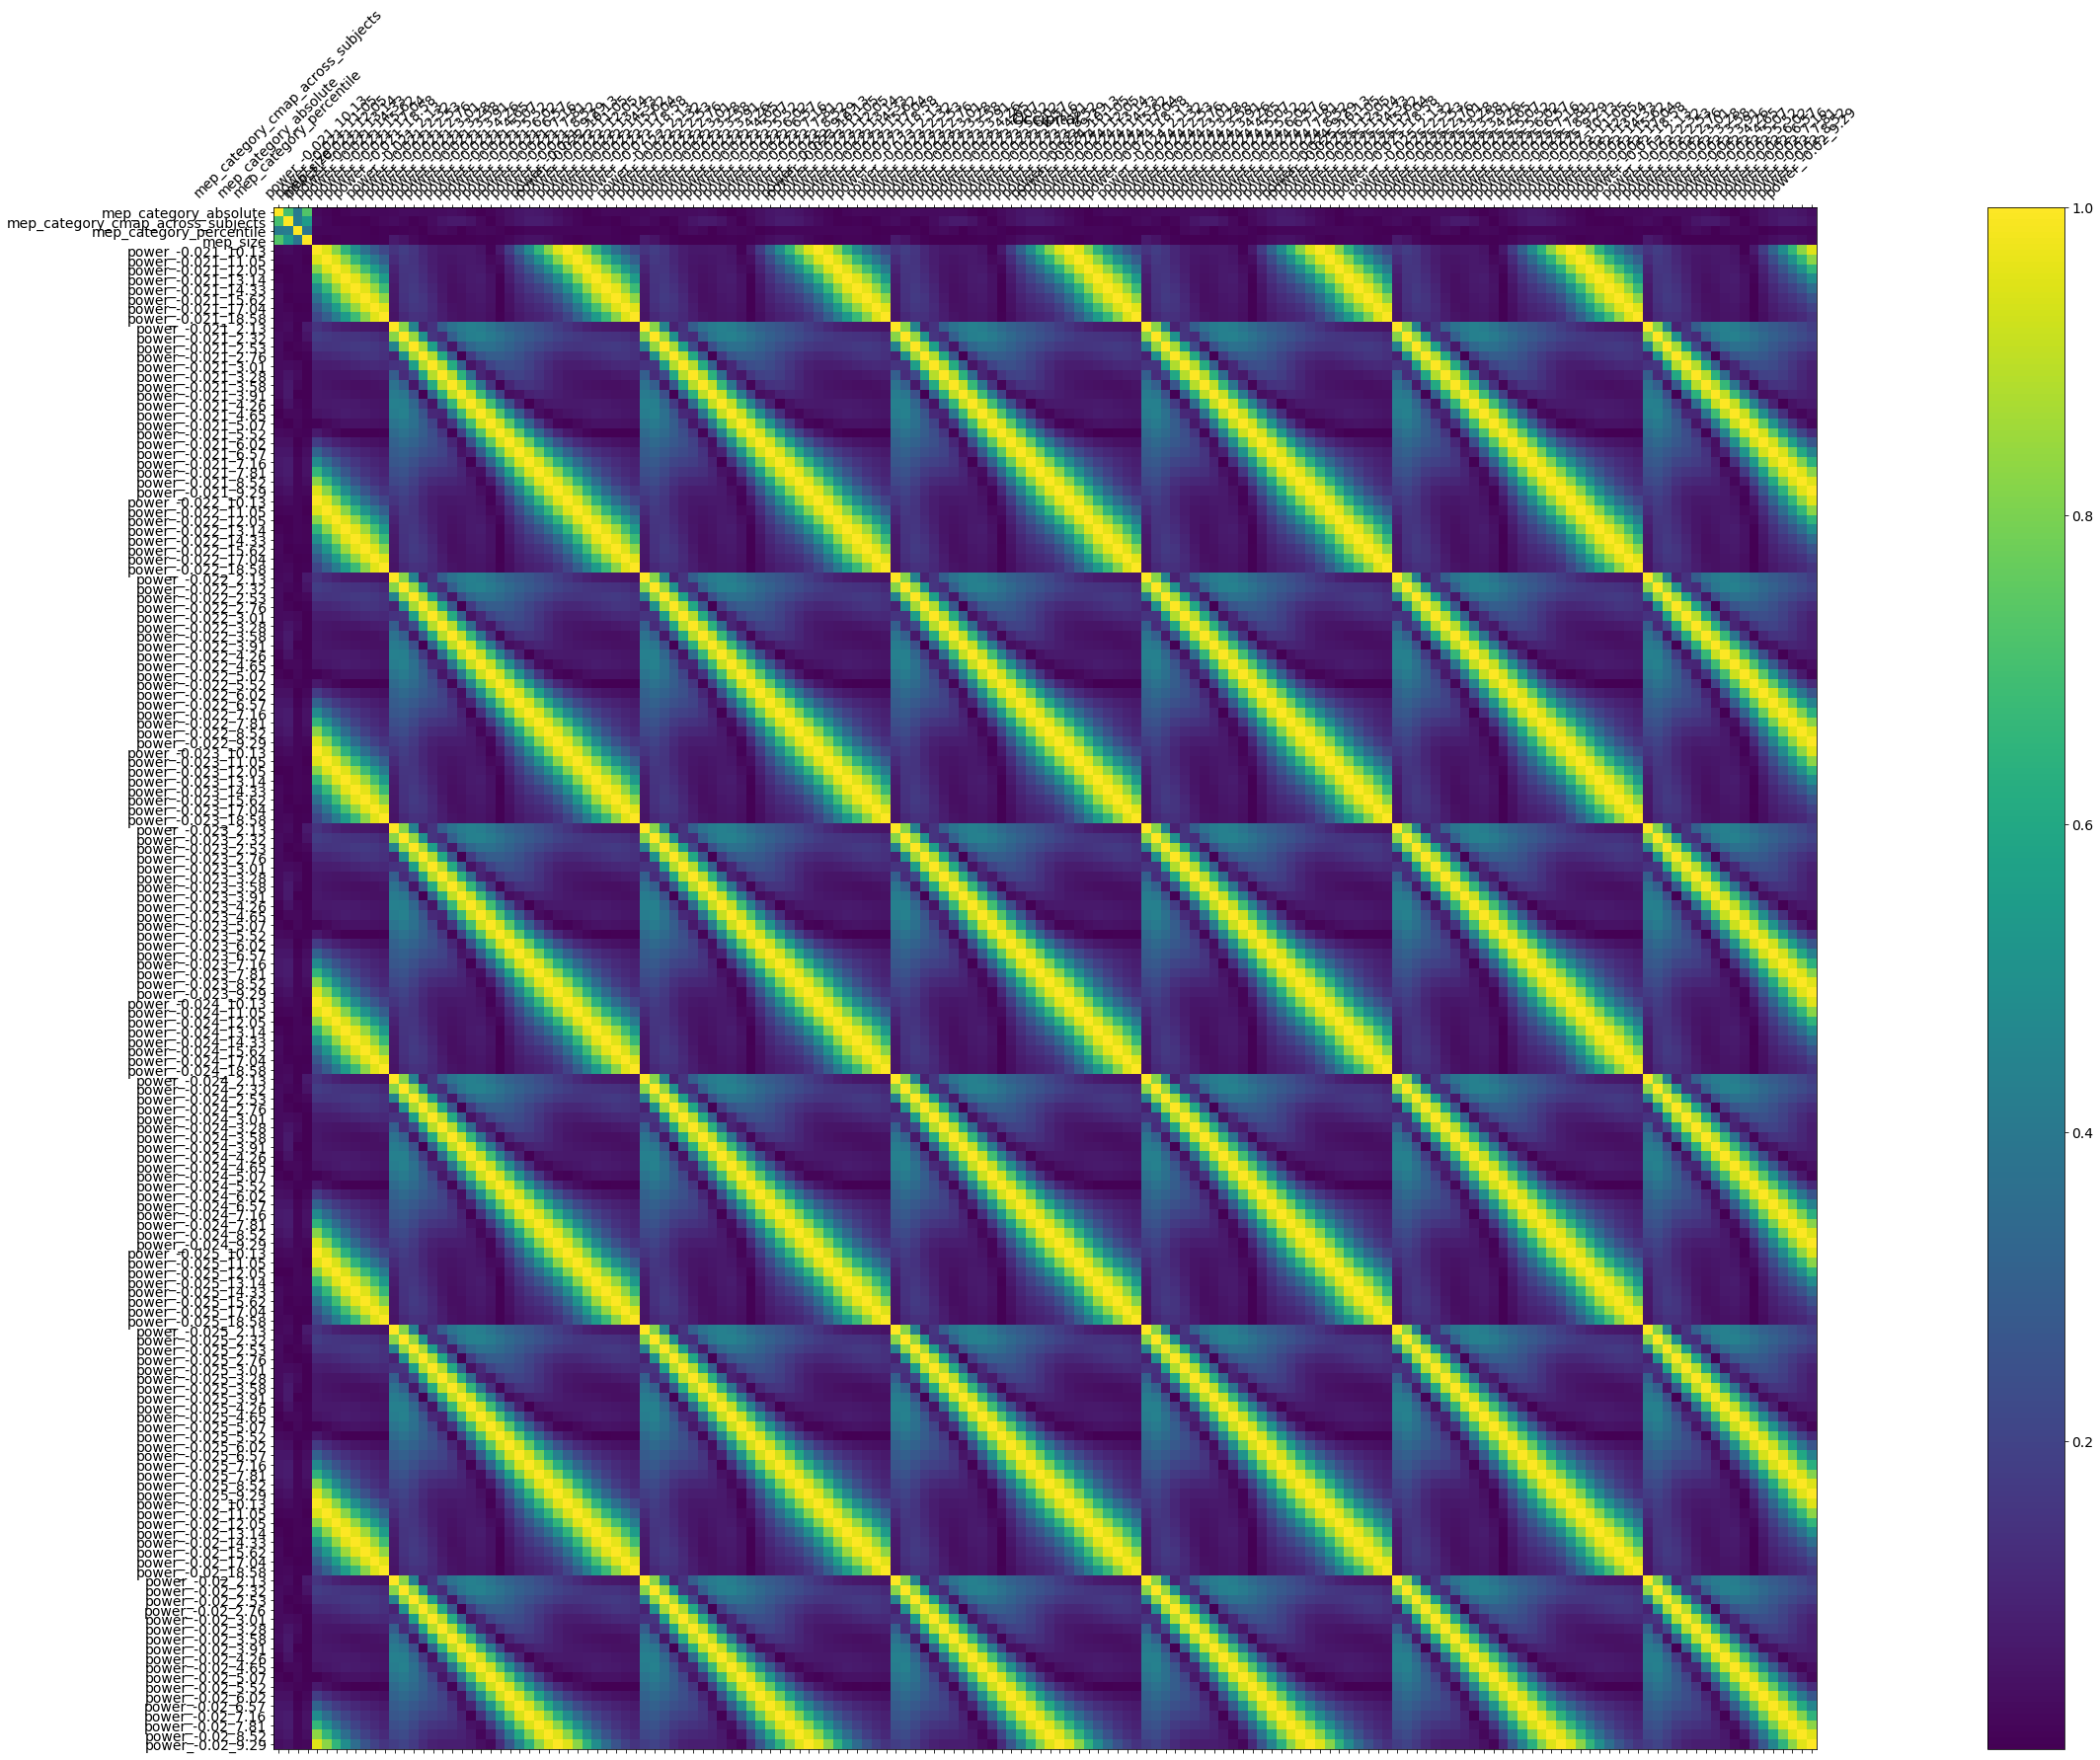

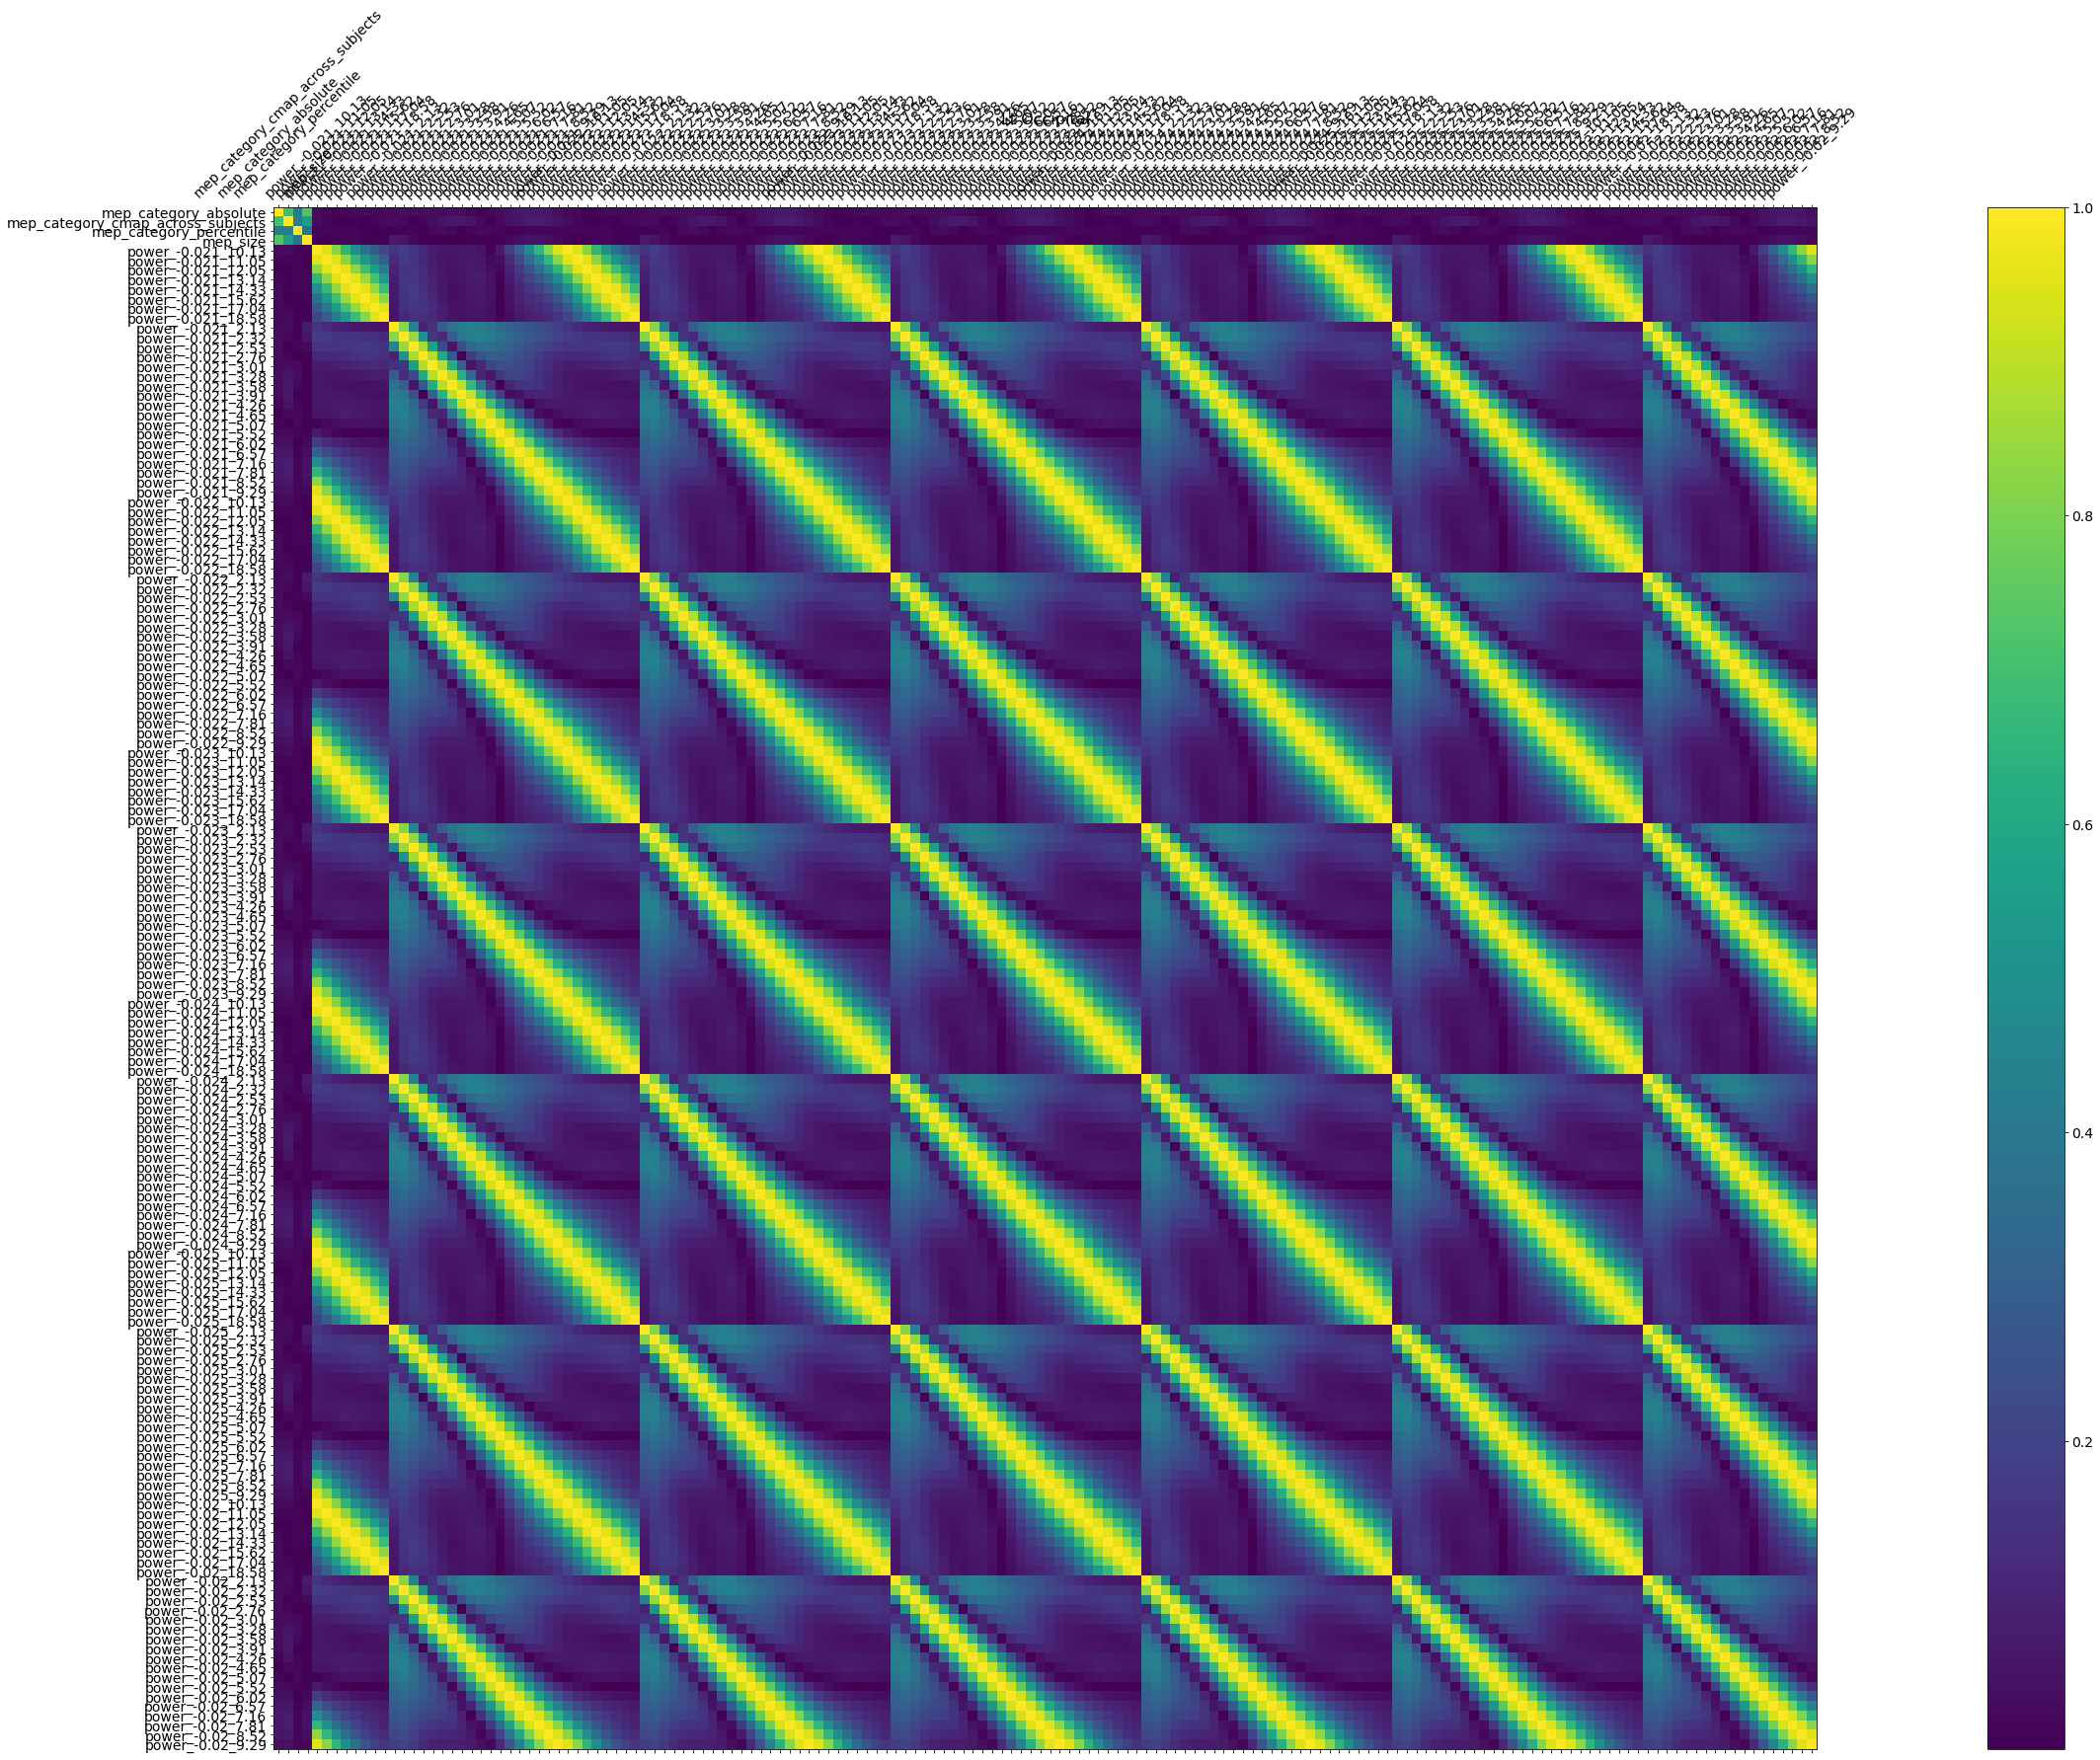

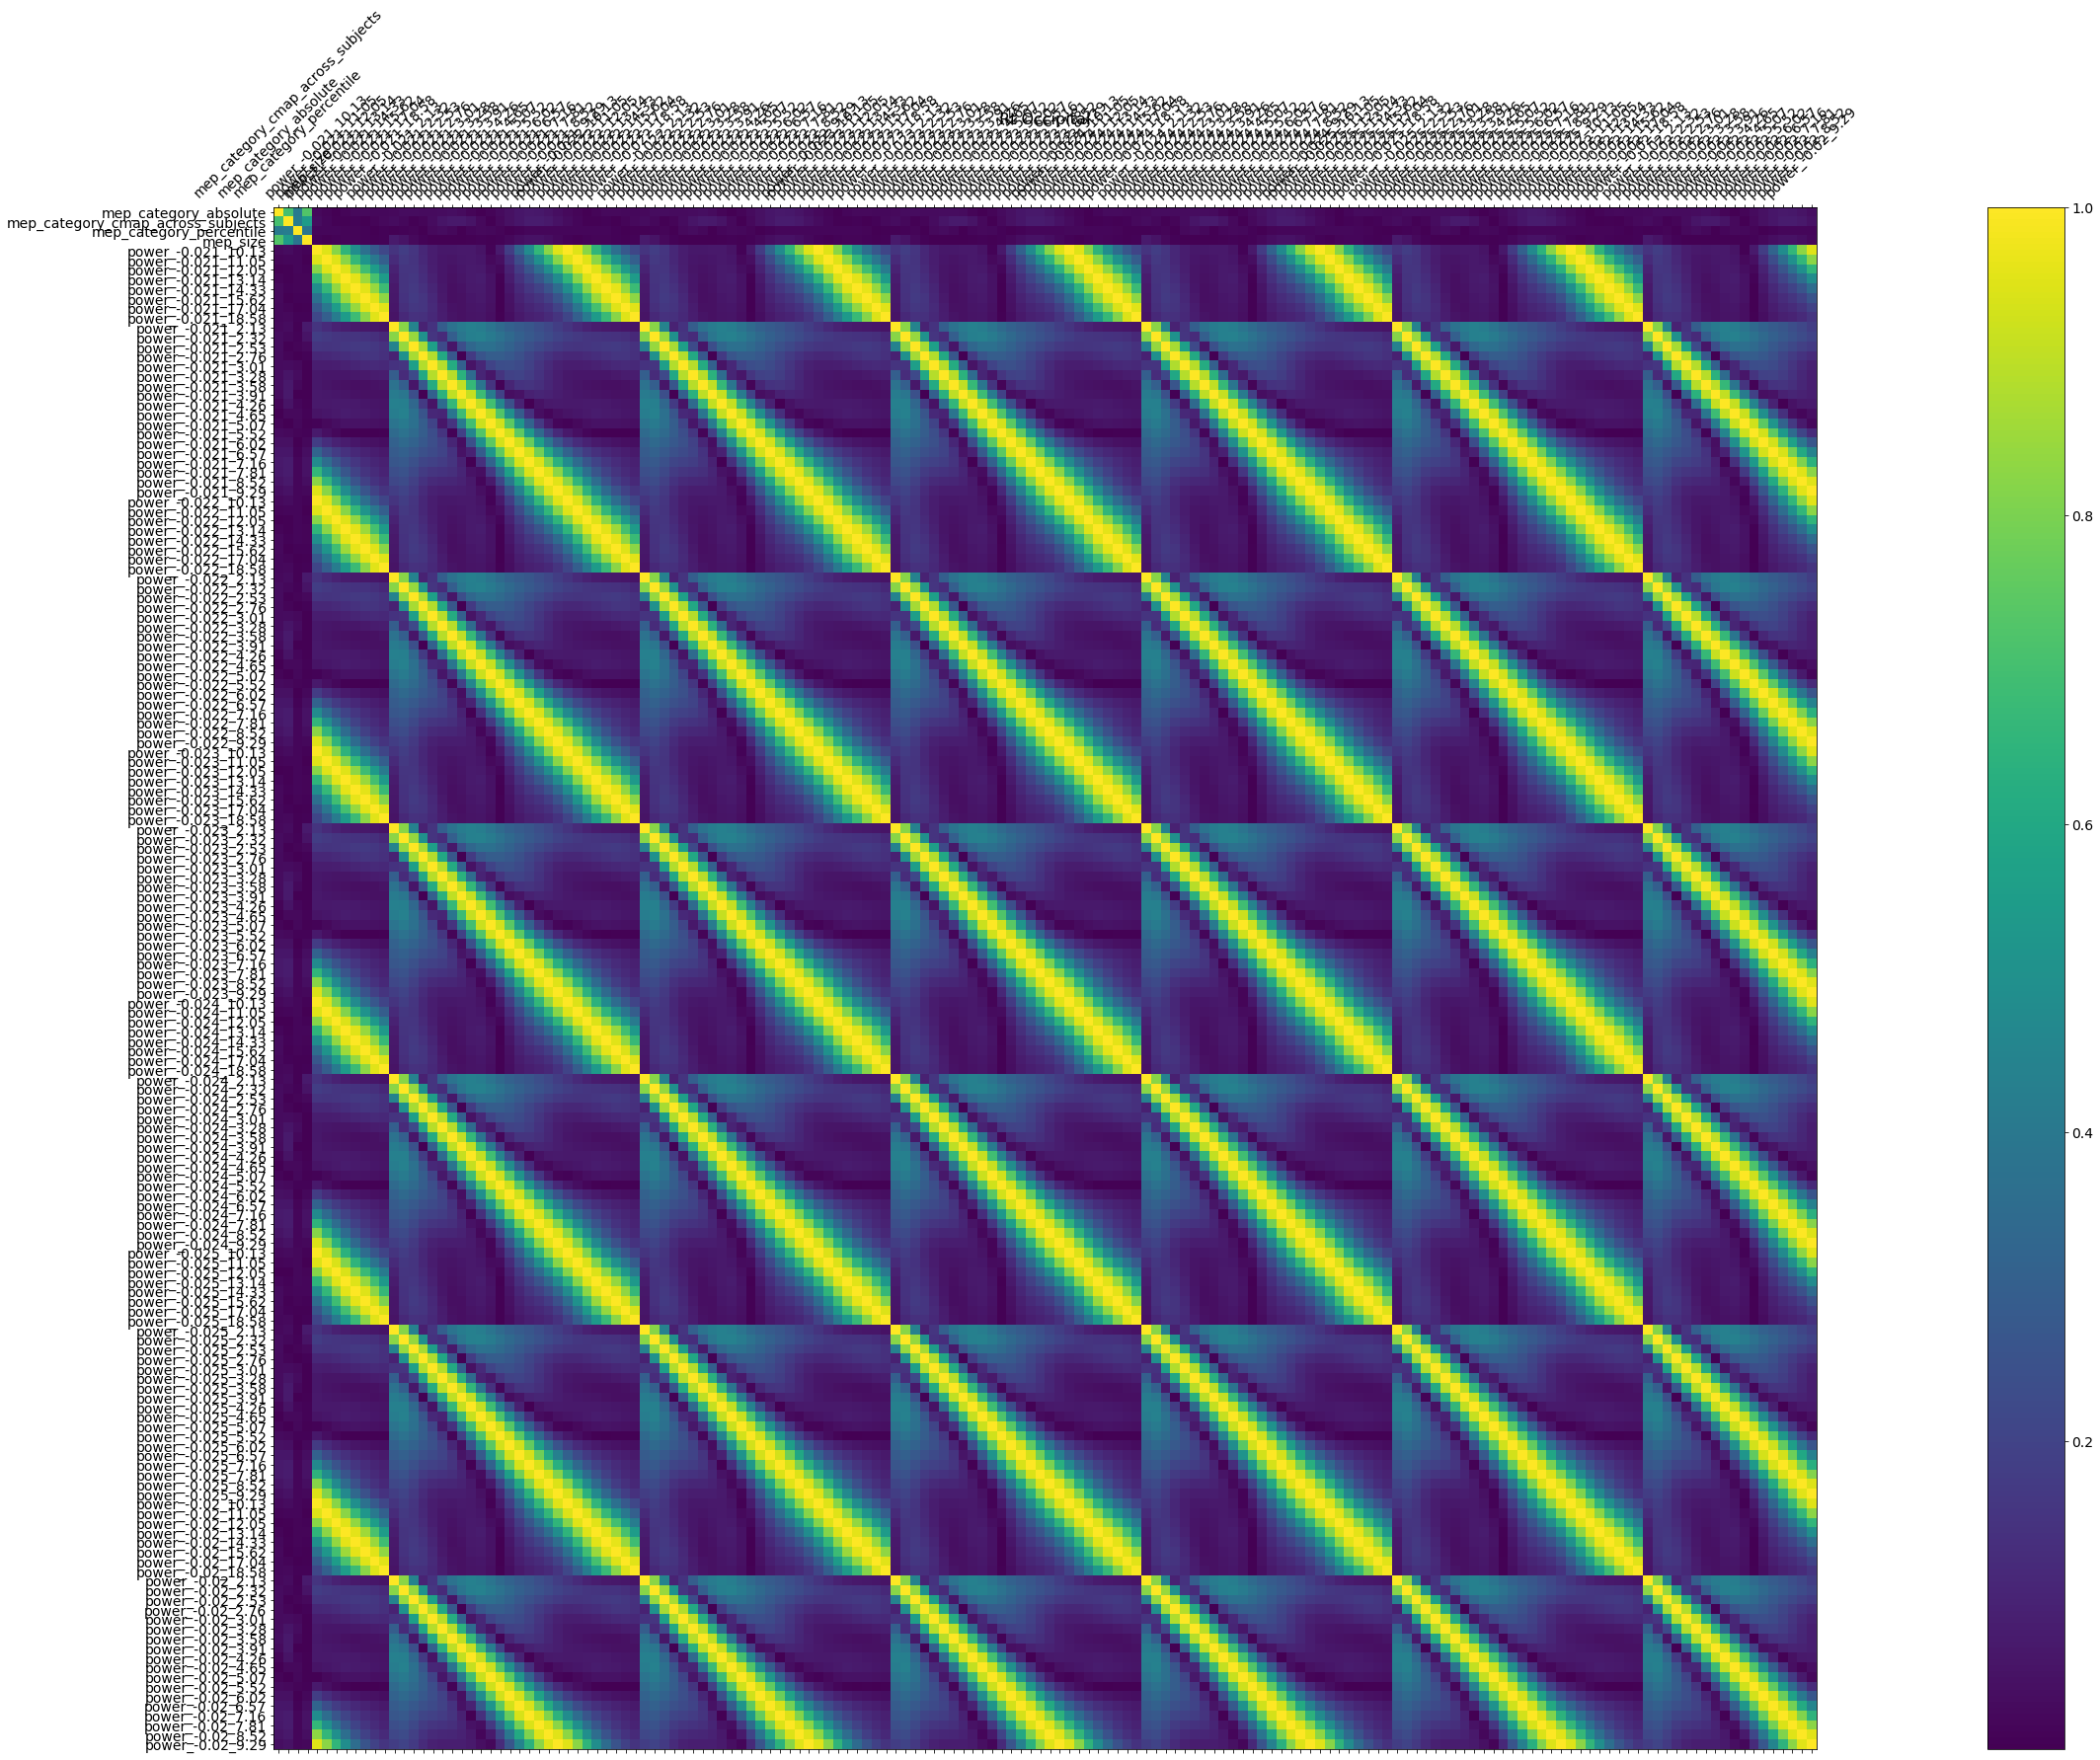

In [20]:
plot_corr(df_corr_ltm1, 'Lt M1')
plot_corr(df_corr_rtm1, 'Rt M1')
plot_corr(df_corr_all, 'All')
plot_corr(df_corr_central, 'Central')
plot_corr(df_corr_ltdlpfc, 'Lt DLPFC')
plot_corr(df_corr_rtdlpfc, 'Lt DLPFC')
plot_corr(df_corr_ltparietal, 'Lt Parietal')
plot_corr(df_corr_rtparietal, 'Rt Parietal')
plot_corr(df_corr_occipital, 'Occipital')
plot_corr(df_corr_ltoccipital, 'Lt Occipital')
plot_corr(df_corr_rtoccipital, 'Rt Occipital')

# Prepare for anova and t-test

In [21]:
def get_dict_of_avg_power(epoch):
    wt_all, wt_ltm1, wt_rtm1, wt_central, wt_ltdlpfc, wt_rtdlpfc, wt_ltparietal, wt_rtparietal, wt_occipital, wt_ltoccipital, wt_rtoccipital = read_wavelets(epoch['sub'], epoch['exp'], epoch['run'], epoch['epoch'])
    wt_all_alpha_mean = crop_wavelet(wt_all, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).mean().mean()
    wt_all_beta_mean = crop_wavelet(wt_all, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).mean().mean()
    wt_all_beta_gamma_mean = crop_wavelet(wt_all, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).mean().mean()
    dct =  {
        'wt_all_alpha_mean': crop_wavelet(wt_all, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_all_beta_mean': crop_wavelet(wt_all, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_all_beta_gamma_mean': crop_wavelet(wt_all, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_all_gamma_mean': crop_wavelet(wt_all, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_ltm1_alpha_mean': crop_wavelet(wt_ltm1, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_ltm1_beta_mean': crop_wavelet(wt_ltm1, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_ltm1_beta_gamma_mean': crop_wavelet(wt_ltm1, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_ltm1_gamma_mean': crop_wavelet(wt_ltm1, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_rtm1_alpha_mean': crop_wavelet(wt_rtm1, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_rtm1_beta_mean': crop_wavelet(wt_rtm1, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_rtm1_beta_gamma_mean': crop_wavelet(wt_rtm1, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_rtm1_gamma_mean': crop_wavelet(wt_rtm1, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_central_alpha_mean': crop_wavelet(wt_central, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_central_beta_mean': crop_wavelet(wt_central, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_central_beta_gamma_mean': crop_wavelet(wt_central, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_central_gamma_mean': crop_wavelet(wt_central, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_ltdlpfc_alpha_mean': crop_wavelet(wt_ltdlpfc, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_ltdlpfc_beta_mean': crop_wavelet(wt_ltdlpfc, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_ltdlpfc_beta_gamma_mean': crop_wavelet(wt_ltdlpfc, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_ltdlpfc_gamma_mean': crop_wavelet(wt_ltdlpfc, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_rtdlpfc_alpha_mean': crop_wavelet(wt_rtdlpfc, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_rtdlpfc_beta_mean': crop_wavelet(wt_rtdlpfc, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_rtdlpfc_beta_gamma_mean': crop_wavelet(wt_rtdlpfc, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_rtdlpfc_gamma_mean': crop_wavelet(wt_rtdlpfc, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_occipital_alpha_mean': crop_wavelet(wt_occipital, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_occipital_beta_mean': crop_wavelet(wt_occipital, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_occipital_beta_gamma_mean': crop_wavelet(wt_occipital, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_occipital_gamma_mean': crop_wavelet(wt_occipital, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_ltoccipital_alpha_mean': crop_wavelet(wt_ltoccipital, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_ltoccipital_beta_mean': crop_wavelet(wt_ltoccipital, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_ltoccipital_beta_gamma_mean': crop_wavelet(wt_ltoccipital, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_ltoccipital_gamma_mean': crop_wavelet(wt_ltoccipital, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_rtoccipital_alpha_mean': crop_wavelet(wt_rtoccipital, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_rtoccipital_beta_mean': crop_wavelet(wt_rtoccipital, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_rtoccipital_beta_gamma_mean': crop_wavelet(wt_rtoccipital, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_rtoccipital_gamma_mean': crop_wavelet(wt_rtoccipital, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_ltparietal_alpha_mean': crop_wavelet(wt_ltparietal, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_ltparietal_beta_mean': crop_wavelet(wt_ltparietal, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_ltparietal_beta_gamma_mean': crop_wavelet(wt_ltparietal, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_ltparietal_gamma_mean': crop_wavelet(wt_ltparietal, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'wt_rtparietal_alpha_mean': crop_wavelet(wt_rtparietal, start_time_millis=-420, end_time_millis=-20, start_freq=8, end_freq=13).values.flatten().mean(),
        'wt_rtparietal_beta_mean': crop_wavelet(wt_rtparietal, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=30).values.flatten().mean(),
        'wt_rtparietal_beta_gamma_mean': crop_wavelet(wt_rtparietal, start_time_millis=-420, end_time_millis=-20, start_freq=13, end_freq=80).values.flatten().mean(),
        'wt_rtparietal_gamma_mean': crop_wavelet(wt_rtparietal, start_time_millis=-420, end_time_millis=-20, start_freq=30, end_freq=80).values.flatten().mean(),
        
        'mep_category_absolute': epoch['mep_category_absolute'],
        'mep_category_absolute_binary': epoch['mep_category_absolute_binary'],
        'mep_category_cmap_across_subjects': epoch['mep_category_cmap_across_subjects'],
        'mep_size': epoch['mep_size'],
        'mep_category_percentile': epoch['mep_category_percentile'],
        'mep_category_cmap': epoch['mep_category_cmap'],
        'mep_category_binary': epoch['mep_category_binary'],
        'mep_category_cmap_category': epoch['mep_category_cmap_category'],
        'mep_category_cmap_category_binary': epoch['mep_category_cmap_category_binary'],
        'sub': epoch['sub'],
        'exp': epoch['exp'],
        'run': epoch['run'],
        'epoch': epoch['epoch']
    }

    dct['wt_all_g2a'] = dct['wt_all_gamma_mean'] / dct['wt_all_alpha_mean']
    dct['wt_all_b2a'] = dct['wt_all_beta_mean'] / dct['wt_all_alpha_mean']
    dct['wt_all_bg2a'] = dct['wt_all_beta_gamma_mean'] / dct['wt_all_alpha_mean']

    dct['wt_ltm1_g2a'] = dct['wt_ltm1_gamma_mean'] / dct['wt_ltm1_alpha_mean']
    dct['wt_ltm1_b2a'] = dct['wt_ltm1_beta_mean'] / dct['wt_ltm1_alpha_mean']
    dct['wt_ltm1_bg2a'] = dct['wt_ltm1_beta_gamma_mean'] / dct['wt_ltm1_alpha_mean']

    dct['wt_rtm1_g2a'] = dct['wt_rtm1_gamma_mean'] / dct['wt_rtm1_alpha_mean']
    dct['wt_rtm1_b2a'] = dct['wt_rtm1_beta_mean'] / dct['wt_rtm1_alpha_mean']
    dct['wt_rtm1_bg2a'] = dct['wt_rtm1_beta_gamma_mean'] / dct['wt_rtm1_alpha_mean']

    dct['wt_central_g2a'] = dct['wt_central_gamma_mean'] / dct['wt_central_alpha_mean']
    dct['wt_central_b2a'] = dct['wt_central_beta_mean'] / dct['wt_central_alpha_mean']
    dct['wt_central_bg2a'] = dct['wt_central_beta_gamma_mean'] / dct['wt_central_alpha_mean']

    dct['wt_ltdlpfc_g2a'] = dct['wt_ltdlpfc_gamma_mean'] / dct['wt_ltdlpfc_alpha_mean']
    dct['wt_ltdlpfc_b2a'] = dct['wt_ltdlpfc_beta_mean'] / dct['wt_ltdlpfc_alpha_mean']
    dct['wt_ltdlpfc_bg2a'] = dct['wt_ltdlpfc_beta_gamma_mean'] / dct['wt_ltdlpfc_alpha_mean']

    dct['wt_rtdlpfc_g2a'] = dct['wt_rtdlpfc_gamma_mean'] / dct['wt_rtdlpfc_alpha_mean']
    dct['wt_rtdlpfc_b2a'] = dct['wt_rtdlpfc_beta_mean'] / dct['wt_rtdlpfc_alpha_mean']
    dct['wt_rtdlpfc_bg2a'] = dct['wt_rtdlpfc_beta_gamma_mean'] / dct['wt_rtdlpfc_alpha_mean']

    dct['wt_occipital_g2a'] = dct['wt_occipital_gamma_mean'] / dct['wt_occipital_alpha_mean']
    dct['wt_occipital_b2a'] = dct['wt_occipital_beta_mean'] / dct['wt_occipital_alpha_mean']
    dct['wt_occipital_bg2a'] = dct['wt_occipital_beta_gamma_mean'] / dct['wt_occipital_alpha_mean']

    dct['wt_ltoccipital_g2a'] = dct['wt_ltoccipital_gamma_mean'] / dct['wt_ltoccipital_alpha_mean']
    dct['wt_ltoccipital_b2a'] = dct['wt_ltoccipital_beta_mean'] / dct['wt_ltoccipital_alpha_mean']
    dct['wt_ltoccipital_bg2a'] = dct['wt_ltoccipital_beta_gamma_mean'] / dct['wt_ltoccipital_alpha_mean']

    dct['wt_rtoccipital_g2a'] = dct['wt_rtoccipital_gamma_mean'] / dct['wt_rtoccipital_alpha_mean']
    dct['wt_rtoccipital_b2a'] = dct['wt_rtoccipital_beta_mean'] / dct['wt_rtoccipital_alpha_mean']
    dct['wt_rtoccipital_bg2a'] = dct['wt_rtoccipital_beta_gamma_mean'] / dct['wt_rtoccipital_alpha_mean']

    dct['wt_ltparietal_g2a'] = dct['wt_ltparietal_gamma_mean'] / dct['wt_ltparietal_alpha_mean']
    dct['wt_ltparietal_b2a'] = dct['wt_ltparietal_beta_mean'] / dct['wt_ltparietal_alpha_mean']
    dct['wt_ltparietal_bg2a'] = dct['wt_ltparietal_beta_gamma_mean'] / dct['wt_ltparietal_alpha_mean']

    dct['wt_rtparietal_g2a'] = dct['wt_rtparietal_gamma_mean'] / dct['wt_rtparietal_alpha_mean']
    dct['wt_rtparietal_b2a'] = dct['wt_rtparietal_beta_mean'] / dct['wt_rtparietal_alpha_mean']
    dct['wt_rtparietal_bg2a'] = dct['wt_rtparietal_beta_gamma_mean'] / dct['wt_rtparietal_alpha_mean']

    return dct

In [22]:
results = Parallel(n_jobs=num_cores)(delayed(get_dict_of_avg_power)(epoch) for idx, epoch in tqdm_notebook(df.iterrows(), total=df.shape[0]))

In [23]:
pd.DataFrame(results).to_excel('70-avg-powers-v3.xlsx')

In [24]:
df_powers = pd.DataFrame(results)

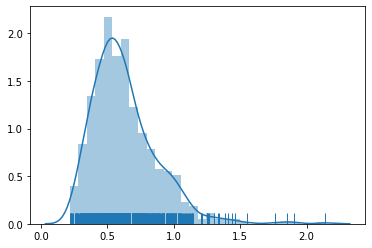

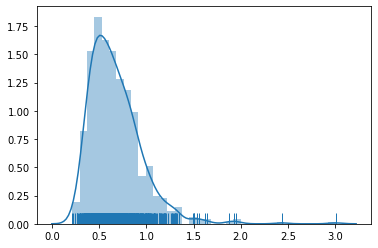

In [25]:
plt.figure()
sns.distplot(df_powers[df_powers['mep_category_cmap_across_subjects'] == 0]['wt_ltm1_b2a'].values, rug=True)
plt.figure()
sns.distplot(df_powers[df_powers['mep_category_cmap_across_subjects'] == 1]['wt_ltm1_b2a'].values, rug=True)

ValueError: x and y must have same first dimension, but have shapes (2,) and (100,)

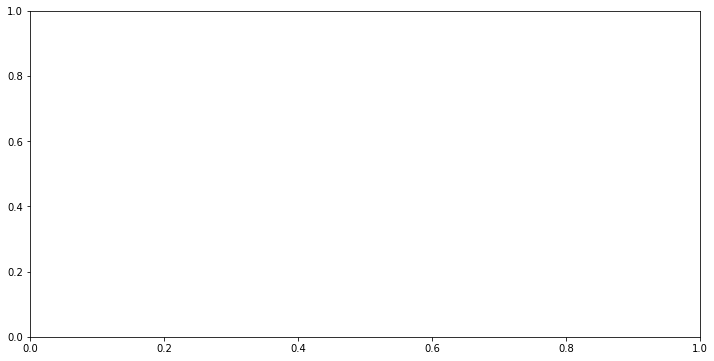

In [27]:
h_s = np.histogram(df_powers[df_powers['mep_category_cmap_across_subjects'] == 0]['wt_ltm1_b2a'].values, bins=np.linspace(0, 4, 100))
h_l = np.histogram(df_powers[df_powers['mep_category_cmap_across_subjects'] == 1]['wt_ltm1_b2a'].values, bins=np.linspace(0, 4, 100))
plt.figure(figsize=(12,6))
plt.plot(h_s, np.append(h_s[0], 0), label='small')
plt.plot(h_l, np.append(h_l[0], 0), label='large')
plt.xlabel('Beta/alpha value')
plt.ylabel('Frequency of occurance')
plt.title('Beta/Alpha Value Histogram')
plt.legend()

In [ ]:
h_s = np.histogram(df_powers[df_powers['mep_category_cmap_across_subjects'] == 0]['wt_ltm1_g2a'].values, bins=np.linspace(0, 4, 100))
h_l = np.histogram(df_powers[df_powers['mep_category_cmap_across_subjects'] == 1]['wt_ltm1_g2a'].values, bins=np.linspace(0, 4, 100))
plt.figure(figsize=(12,6))
plt.plot(h[1], np.append(h_s[0], 0), label='small')
plt.plot(h[1], np.append(h_l[0], 0), label='large')
plt.xlabel('Gamma/alpha value')
plt.ylabel('Frequency of occurance')
plt.title('Gamma/Alpha Value Histogram')
plt.legend()

In [ ]:
h_s = np.histogram(df_powers[df_powers['mep_category_cmap_across_subjects'] == 0]['wt_ltm1_bg2a'].values, bins=np.linspace(0, 4, 100))
h_l = np.histogram(df_powers[df_powers['mep_category_cmap_across_subjects'] == 1]['wt_ltm1_bg2a'].values, bins=np.linspace(0, 4, 100))
plt.figure(figsize=(12,6))
plt.plot(h[1], np.append(h_s[0], 0), label='small')
plt.plot(h[1], np.append(h_l[0], 0), label='large')
plt.xlabel('Beta+gamma/alpha value')
plt.ylabel('Frequency of occurance')
plt.title('Beta+gamma/Alpha Value Histogram')
plt.legend()